# Cleaning the time formats in the play-by-play data

Author: Justin Brown

Dated: 08/05/2025

---

The idea for cleaning the time formats is a 3-step process:
1. Identify patterns in the 'WCTIMESTRING' column that can be translated into a standard format. 
2. Translate those patterns into a standard format, such as 12-hour standard.
3. Exclude cleaned games that have weird event densities, such as too many events in a short time period, or too few events in a long time period.



## Finding WCTIMESTRING Patterns

The 'WCTIMESTRING' column does not all have the same format. However, some formats are consistent across the entire game, and may be translated into a standard format that could be used for calculating game durations accurately. 

In order to know if a format is translateable, we need to first identify if there is a way to represent it as a 
regular expression. If we can, and the pattern is either mutually exclusive to other patterns or ordered by specificity, 
then it's more likely that the format can be translated.

A few differentiating factors between time formats to consider are:
- **Hour Range**: Does the hour range from 0-23, 1-12, or 0-99, or 0-259, or is it unbounded?
- **Minute Range**: Does the minute range from 0-59 or is it not bounded to 60?
- **AM/PM Presence**: Does the time format always include AM/PM, sometimes include it, or never include it?
- **AM/PM Turnover**: Does the time format turnover between AM and PM at 12:00 PM, 12:00 AM, 0:00 AM, or 24:00 AM?
- **AM/PM String Consistency**: Can 'AM' have random instances of 'A', 'PM' have random instances of 'P', or are they always consistent? If they are consistent, can they be interchanged?
- **Negative Hours**: Does the time format allow negative hours, such as -1:00 AM, -2:00 PM, or -99:00 AM?
- **Negative Minutes**: Does the time format allow negative minutes, such as 0:0-30 AM, 0:0-30 PM, or -1:0-30 AM, or 0:-30 PM?
- **Zero-Padding**: Does the time format allow zero-padding, such as 01:00 AM, 01:00 PM, or does it not allow it, such as 1:00 AM, 1:00 PM?
- **Sticky AM/PM**: Does the time format remain PM once it passes a potential turnover point such as 12:00 PM, such as 13:00 PM, 25:00 PM, or 101:00 PM?

### Defining the Patterns

TODO: 
- show the breakdown for each pattern in a table.

The cell below is a list of the currently best known patterns patterns that match the time formats found in the data.

They may not be comprehensive or completely accurate and are a work in progress.

In [2]:
import re

# Original time formats.
TIME_FORMATS = {
    '12_standard': r'^(?:0?[1-9]|1[0-2]):[0-5][0-9] [AP]M$', # Standard 12-hour
    '24_standard': r'^(?:0?[0-9]|1[0-9]|2[0-3]):[0-5][0-9]$', # Standard 24-hour
    '24_am_pm_with_sticky_pm': r'^(?:0[0-9]|1[0-1]|1[3-9]|2[0-3]):[0-5][0-9] [AP]M$|^12:[0-5][0-9] PM$', # 24-hour always including AM/PM, 12 only allowed with PM
    '24_optional_am_pm': r'^(?:0?[0-9]|1[0-1]|1[3-9]|2[0-3]):[0-5][0-9](?: ?[AP]M)?$|^12:[0-5][0-9]$|^12:[0-5][0-9] ?PM$', # 24-hour sometimes with AM/PM
    '259_hr_both_am_pm': r'^(?:\d{1,3}):[0-5]\d (?:AM|PM)$', # Forms 11:42 AM, 12:00 PM, 1:01 PM, 176:57 AM, can have inconsistent turnover.
    '99_hr_am_pm_with_sticky_pm': r'^(?!12:00 AM$)(?!24:00 AM)[0-9]{2}:[0-5][0-9] ?[AP]M$', # 99-hour always with AM/PM
    '99_hr_optional_am_pm': r'^(?!12:00 AM$)(?:0?[0-9]|[1-9]|[1-9][0-9]|99):[0-5][0-9](?: ?[AP]M)?$', # 99-hour sometimes with AM/PM
    '0_or_1_hr_0_minus_minutes_am_only_with_turnover': r'^(?:0:(?:0-(?:[1-5]?\d)|0{2}|[0-5]?\d)|1:(?:[0-5]\d)) AM$', # Forms 0:0-XX AM or 1:XX AM
    '0_or_1_hr_0_minus_minutes_pm_only_with_turnover': r'^(?:0:(?:0-(?:[1-5]?\d)|0{2}|[0-5]?\d)|1:(?:[0-5]\d)) PM$', # Forms 0:0-XX PM or 1:XX PM
    '0_hr_0_minus_minutes_turnover': r'^0:(?:0(?:-[0-5][0-9])?|[0-5][0-9]) [AP]M$', # Forms 0:0-XX or 0:XX or 0:0-X with both AM and PM
    '259_hr_am_pm_with_sticky_pm': r'^(?:0:[0-5][0-9]|[1-9]:[0-5][0-9]|1[0-1]:[0-5][0-9]) AM$|^(?:12:[0-5][0-9]|1[3-9]:[0-5][0-9]|[2-9][0-9]:[0-5][0-9]|1[0-9]{2}:[0-5][0-9]|2[0-5][0-9]:[0-5][0-9]) PM$', # Forms 0:00 AM, 11:59 AM, 12:00 PM, ... 259:59 PM
    'minus_12_hr_0_minus_minutes_am_or_a_no_turnover': r'^-\d{1,2}:0-(?:[1-5]?\d) A$|^-\d{1,2}:0-(?:[1-5]?\d) AM$|^-\d{1,2}:0{2} A$|^-\d{1,2}:0{2} AM$|^-\d{1,2}:0-(?:[1-9]|[1-5]\d) A$|^-\d{1,2}:0-(?:[1-9]|[1-5]\d) AM$|^-\d{1,2}:0-(?:[1-9]|[1-5]\d) A$|^-\d{1,2}:0-(?:[1-9]|[1-5]\d) AM$|^-\d{1,2}:00 AM$', # Forms -10:0-XX A or -10:0-XX AM, -10:00 A or -10:00 AM
    'minus_199_hr_0_minus_minutes_optional_am_or_a': r"^-1\d{2}:(?:0-(?:[1-5]?\d)|00)(?: ?A(?:M)?)?$", # Matches: -180:0-25, -180:0-9 A, -179:00 AM, etc.
    'minus_12_hr_0_minus_minutes_positive_00_minutes_optional_am_or_a_with_4am_exception_and_minus_00_minutes_am_only_exception': r"^(?:-\d{1,2}:0-(?:[1-5]?\d) ?A(?:M)?|-\d{1,2}:00 AM|4:00 AM)$", # Matches: -10:0-48 A, -10:0-9 AM, -10:00 AM, -9:00 AM, and 4:00 AM NOT -9:00 A.
}

# Time formats split into sections
TFS = {
    '12_hr': r'(?:[1-9]|1[0-2])',  # Matches 1-12, no leading zero
    '24_hr': r'(?:[0-9]|1[0-9]|2[0-3])',  # Matches 0-23 with no leading zero
    '36_hr': r'(?:[0-9]|1[0-9]|2[0-9]|3[0-5])',  # Matches 0-35 with no leading zero
    '48_hr': r'(?:[0-9]|1[0-9]|2[0-9]|3[0-9]|4[0-8])',  # Matches 0-48 with no leading zero
    '72_hr': r'(?:[0-9]|[1-6][0-9]|7[0-2])',  # Matches 0-72 with no leading zero
    '96_hr': r'(?:[0-9]|[1-8][0-9]|9[0-6])',  # Matches 0-96 with no leading zero
    '360_hr': r'(?:[0-9]|[1-9][0-9]|[1-2][0-9]{2}|3[0-5][0-9]|360)', # Matches 0-360 with no leading zero
    '999_hr': r'(?:[0-9]|[1-9][0-9]|[1-9][0-9]{2}|999)',  # Matches 0-999 with no leading zero
    'neg_12_hr': r'-(?:[0-9]|1[0-2])',  # Matches -0 to -12 with no leading zero
    'neg_180_hr': r'-(?:[0-9]|[1-9][0-9]|1[0-7][0-9]|180)',  # Matches -0 to -180 with no leading zero
    'neg_12_and_4am_hr': r'(?:-(?:[0-9]|1[0-2])|4)',  # Matches -1 to -12 with no leading zero or positive 4 hour AM
    '60_min': r'[0-5][0-9]', # Matches 0-60 minutes only, formatted as :30, :45 AM, etc.
    '0_neg_min': r'0-(?:[0-5][0-9]|[0-9])(?![0-9])', # Matches 0-60 minutes only, formatted as :0-XX or :0-X, :0-XX AM, etc.
    'mixed_0_neg_pos_min': r'(?:0-(?:[0-5][0-9]|[0-9])(?![0-9])|[0-5][0-9])', # Only :0-00 to :0-59 and :00 to :59
    'no_am_or_pm_always': r'(?<![A-Za-z])$', # Matches strings that do not end with any letter (so not AM, PM, A, P, etc.)
    'am_always': r' AM$', # Matches strings that end with AM
    'pm_always': r' PM$', # Matches strings that end with PM
    'am_or_pm_always': r' [AP]M$', # Matches strings that end with AM or PM
    'am_or_a_always': r' A(M)?$', # Matches strings that end with A or AM
    'am_or_a_or_none': r'(?: AM| A|(?<![A-Za-z])$)', # Matches strings that end with AM, PM, A, or neither
}

# Time formats combined
TFC = {
    '12_hr_standard_no_am_or_pm': r'^' + TFS['12_hr'] + r':' + TFS['60_min'] + TFS['no_am_or_pm_always'],
    '12_hr_standard_am': r'^' + TFS['12_hr'] + r':' + TFS['60_min'] + TFS['am_always'],
    '12_hr_standard_pm': r'^' + TFS['12_hr'] + r':' + TFS['60_min'] + TFS['pm_always'],
    '12_hr_standard_am_or_pm': r'^' + TFS['12_hr'] + r':' + TFS['60_min'] + TFS['am_or_pm_always'],
    '12_hr_standard_am_or_a': r'^' + TFS['12_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_always'],
    '12_hr_standard_am_or_a_or_none': r'^' + TFS['12_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_or_none'],
    '12_hr_0_neg_minutes_no_am_or_pm_always': r'^' + TFS['12_hr'] + r':' + TFS['0_neg_min'] + TFS['no_am_or_pm_always'],
    '12_hr_0_neg_minutes_am_always': r'^' + TFS['12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_always'],
    '12_hr_0_neg_minutes_pm_always': r'^' + TFS['12_hr'] + r':' + TFS['0_neg_min'] + TFS['pm_always'],
    '12_hr_0_neg_minutes_am_or_pm_always': r'^' + TFS['12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_pm_always'],
    '12_hr_0_neg_minutes_am_or_a_always': r'^' + TFS['12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_always'],
    '12_hr_0_neg_minutes_am_or_a_or_none': r'^' + TFS['12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_or_none'],
    '12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always': r'^' + TFS['12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['no_am_or_pm_always'],
    '12_hr_mixed_0_neg_pos_minutes_am_always': r'^' + TFS['12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_always'],
    '12_hr_mixed_0_neg_pos_minutes_pm_always': r'^' + TFS['12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['pm_always'],
    '12_hr_mixed_0_neg_pos_minutes_am_or_pm_always': r'^' + TFS['12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_pm_always'],
    '12_hr_mixed_0_neg_pos_minutes_am_or_a_always': r'^' + TFS['12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_always'],
    '12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none': r'^' + TFS['12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_or_none'],
    '24_hr_standard_no_am_or_pm': r'^' + TFS['24_hr'] + r':' + TFS['60_min'] + TFS['no_am_or_pm_always'],
    '24_hr_standard_am': r'^' + TFS['24_hr'] + r':' + TFS['60_min'] + TFS['am_always'],
    '24_hr_standard_pm': r'^' + TFS['24_hr'] + r':' + TFS['60_min'] + TFS['pm_always'],
    '24_hr_standard_am_or_pm': r'^' + TFS['24_hr'] + r':' + TFS['60_min'] + TFS['am_or_pm_always'],
    '24_hr_standard_am_or_a': r'^' + TFS['24_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_always'],
    '24_hr_standard_am_or_a_or_none': r'^' + TFS['24_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_or_none'],
    '24_hr_0_neg_minutes_no_am_or_pm_always': r'^' + TFS['24_hr'] + r':' + TFS['0_neg_min'] + TFS['no_am_or_pm_always'],
    '24_hr_0_neg_minutes_am_always': r'^' + TFS['24_hr'] + r':' + TFS['0_neg_min'] + TFS['am_always'],
    '24_hr_0_neg_minutes_pm_always': r'^' + TFS['24_hr'] + r':' + TFS['0_neg_min'] + TFS['pm_always'],
    '24_hr_0_neg_minutes_am_or_pm_always': r'^' + TFS['24_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_pm_always'],
    '24_hr_0_neg_minutes_am_or_a_always': r'^' + TFS['24_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_always'],
    '24_hr_0_neg_minutes_am_or_a_or_none': r'^' + TFS['24_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_or_none'],
    '24_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always': r'^' + TFS['24_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['no_am_or_pm_always'],
    '24_hr_mixed_0_neg_pos_minutes_am_always': r'^' + TFS['24_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_always'],
    '24_hr_mixed_0_neg_pos_minutes_pm_always': r'^' + TFS['24_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['pm_always'],
    '24_hr_mixed_0_neg_pos_minutes_am_or_pm_always': r'^' + TFS['24_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_pm_always'],
    '24_hr_mixed_0_neg_pos_minutes_am_or_a_always': r'^' + TFS['24_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_always'],
    '24_hr_mixed_0_neg_pos_minutes_am_or_a_or_none': r'^' + TFS['24_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_or_none'],
    '999_hr_standard_no_am_or_pm': r'^' + TFS['999_hr'] + r':' + TFS['60_min'] + TFS['no_am_or_pm_always'],
    '999_hr_standard_am': r'^' + TFS['999_hr'] + r':' + TFS['60_min'] + TFS['am_always'],
    '999_hr_standard_pm': r'^' + TFS['999_hr'] + r':' + TFS['60_min'] + TFS['pm_always'],
    '999_hr_standard_am_or_pm': r'^' + TFS['999_hr'] + r':' + TFS['60_min'] + TFS['am_or_pm_always'],
    '999_hr_standard_am_or_a': r'^' + TFS['999_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_always'],
    '999_hr_standard_am_or_a_or_none': r'^' + TFS['999_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_or_none'],
    '999_hr_0_neg_minutes_no_am_or_pm_always': r'^' + TFS['999_hr'] + r':' + TFS['0_neg_min'] + TFS['no_am_or_pm_always'],
    '999_hr_0_neg_minutes_am_always': r'^' + TFS['999_hr'] + r':' + TFS['0_neg_min'] + TFS['am_always'],
    '999_hr_0_neg_minutes_pm_always': r'^' + TFS['999_hr'] + r':' + TFS['0_neg_min'] + TFS['pm_always'],
    '999_hr_0_neg_minutes_am_or_pm_always': r'^' + TFS['999_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_pm_always'],
    '999_hr_0_neg_minutes_am_or_a_always': r'^' + TFS['999_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_always'],
    '999_hr_0_neg_minutes_am_or_a_or_none': r'^' + TFS['999_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_or_none'],
    '999_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always': r'^' + TFS['999_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['no_am_or_pm_always'],
    '999_hr_mixed_0_neg_pos_minutes_am_always': r'^' + TFS['999_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_always'],
    '999_hr_mixed_0_neg_pos_minutes_pm_always': r'^' + TFS['999_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['pm_always'],
    '999_hr_mixed_0_neg_pos_minutes_am_or_pm_always': r'^' + TFS['999_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_pm_always'],
    '999_hr_mixed_0_neg_pos_minutes_am_or_a_always': r'^' + TFS['999_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_always'],
    '999_hr_mixed_0_neg_pos_minutes_am_or_a_or_none': r'^' + TFS['999_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_or_none'],
    'neg_12_hr_standard_no_am_or_pm': r'^' + TFS['neg_12_hr'] + r':' + TFS['60_min'] + TFS['no_am_or_pm_always'],
    'neg_12_hr_standard_am': r'^' + TFS['neg_12_hr'] + r':' + TFS['60_min'] + TFS['am_always'],
    'neg_12_hr_standard_pm': r'^' + TFS['neg_12_hr'] + r':' + TFS['60_min'] + TFS['pm_always'],
    'neg_12_hr_standard_am_or_pm': r'^' + TFS['neg_12_hr'] + r':' + TFS['60_min'] + TFS['am_or_pm_always'],
    'neg_12_hr_standard_am_or_a': r'^' + TFS['neg_12_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_always'],
    'neg_12_hr_standard_am_or_a_or_none': r'^' + TFS['neg_12_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_or_none'],
    'neg_12_hr_0_neg_minutes_no_am_or_pm_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['0_neg_min'] + TFS['no_am_or_pm_always'],
    'neg_12_hr_0_neg_minutes_am_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_always'],
    'neg_12_hr_0_neg_minutes_pm_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['0_neg_min'] + TFS['pm_always'],
    'neg_12_hr_0_neg_minutes_am_or_pm_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_pm_always'],
    'neg_12_hr_0_neg_minutes_am_or_a_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_always'],
    'neg_12_hr_0_neg_minutes_am_or_a_or_none': r'^' + TFS['neg_12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_or_none'],
    'neg_12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['no_am_or_pm_always'],
    'neg_12_hr_mixed_0_neg_pos_minutes_am_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_always'],
    'neg_12_hr_mixed_0_neg_pos_minutes_pm_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['pm_always'],
    'neg_12_hr_mixed_0_neg_pos_minutes_am_or_pm_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_pm_always'],
    'neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_always'],
    'neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none': r'^' + TFS['neg_12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_or_none'],
    'neg_180_hr_standard_no_am_or_pm': r'^' + TFS['neg_180_hr'] + r':' + TFS['60_min'] + TFS['no_am_or_pm_always'],
    'neg_180_hr_standard_am': r'^' + TFS['neg_180_hr'] + r':' + TFS['60_min'] + TFS['am_always'],
    'neg_180_hr_standard_pm': r'^' + TFS['neg_180_hr'] + r':' + TFS['60_min'] + TFS['pm_always'],
    'neg_180_hr_standard_am_or_pm': r'^' + TFS['neg_180_hr'] + r':' + TFS['60_min'] + TFS['am_or_pm_always'],
    'neg_180_hr_standard_am_or_a': r'^' + TFS['neg_180_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_always'],
    'neg_180_hr_standard_am_or_a_or_none': r'^' + TFS['neg_180_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_or_none'],
    'neg_180_hr_0_neg_minutes_no_am_or_pm_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['0_neg_min'] + TFS['no_am_or_pm_always'],
    'neg_180_hr_0_neg_minutes_am_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['0_neg_min'] + TFS['am_always'],
    'neg_180_hr_0_neg_minutes_pm_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['0_neg_min'] + TFS['pm_always'],
    'neg_180_hr_0_neg_minutes_am_or_pm_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_pm_always'],
    'neg_180_hr_0_neg_minutes_am_or_a_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_always'],
    'neg_180_hr_0_neg_minutes_am_or_a_or_none': r'^' + TFS['neg_180_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_or_none'],
    'neg_180_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['no_am_or_pm_always'],
    'neg_180_hr_mixed_0_neg_pos_minutes_am_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_always'],
    'neg_180_hr_mixed_0_neg_pos_minutes_pm_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['pm_always'],
    'neg_180_hr_mixed_0_neg_pos_minutes_am_or_pm_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_pm_always'],
    'neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_always'],
    'neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_or_none': r'^' + TFS['neg_180_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_or_none'],
    'neg_12_and_4am_hr_standard_no_am_or_pm': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['60_min'] + TFS['no_am_or_pm_always'],
    'neg_12_and_4am_hr_standard_am': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['60_min'] + TFS['am_always'],
    'neg_12_and_4am_hr_standard_pm': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['60_min'] + TFS['pm_always'],
    'neg_12_and_4am_hr_standard_am_or_pm': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['60_min'] + TFS['am_or_pm_always'],
    'neg_12_and_4am_hr_standard_am_or_a': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_always'],
    'neg_12_and_4am_hr_standard_am_or_a_or_none': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_or_none'],
    'neg_12_and_4am_hr_0_neg_minutes_no_am_or_pm_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['0_neg_min'] + TFS['no_am_or_pm_always'],
    'neg_12_and_4am_hr_0_neg_minutes_am_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['0_neg_min'] + TFS['am_always'],
    'neg_12_and_4am_hr_0_neg_minutes_pm_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['0_neg_min'] + TFS['pm_always'],
    'neg_12_and_4am_hr_0_neg_minutes_am_or_pm_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_pm_always'],
    'neg_12_and_4am_hr_0_neg_minutes_am_or_a_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_always'],
    'neg_12_and_4am_hr_0_neg_minutes_am_or_a_or_none': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_or_none'],
    'neg_12_and_4am_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['no_am_or_pm_always'],
    'neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_always'],
    'neg_12_and_4am_hr_mixed_0_neg_pos_minutes_pm_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['pm_always'],
    'neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_pm_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_pm_always'],
    'neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_a_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_always'],
    'neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_a_or_none': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_or_none'],
}

### Pattern analysis

#### Hours:

 The following patterns appear to cover all hour formats:
```python
'12_hr': r'^(?:[1-9]|1[0-2]):.*',  # Matches 1-12, no leading zero
'24_hr': r'^(?:[0-9]|1[0-9]|2[0-3]):.*',  # Matches 0-23 with no leading zero
'36_hr': r'^(?:[0-9]|1[0-9]|2[0-9]|3[0-5]):.*',  # Matches 0-35 with no leading zero
'48_hr': r'^(?:[0-9]|1[0-9]|2[0-9]|3[0-9]|4[0-8]):.*',  # Matches 0-48 with no leading zero
'72_hr': r'^(?:[0-9]|[1-6][0-9]|7[0-2]):.*',  # Matches 0-72 with no leading zero
'96_hr': r'^(?:[0-9]|[1-8][0-9]|9[0-6]):.*',  # Matches 0-96 with no leading zero
'360_hr': r'^(?:[0-9]|[1-9][0-9]|[1-2][0-9]{2}|3[0-5][0-9]|360):.*', # Matches 0-360 with no leading zero
'999_hr': r'^(?:[0-9]|[1-9][0-9]|[1-9][0-9]{2}|999):.*',  # Matches 0-999 with no leading zero
'neg_12_hr': r'^-(?:[0-9]|1[0-2]):.*',  # Matches -0 to -12 with no leading zero
'neg_180_hr': r'^-(?:[0-9]|[1-9][0-9]|1[0-7][0-9]|180):.*',  # Matches -0 to -180 with no leading zero
'neg_12_and_4am_hr': r'^-(?:[0-9]|1[0-2]):.*|^4:00 AM',  # Matches -1 to -12 with no leading zero or 4:00 AM only
```

Frequencies of first 5 seasons:

| Time_Format         | # without overlap    | # with overlap     |
|---------------------|----------------------|--------------------|
| 12_hr               |                  549 |                549 |
| 24_hr               |                  667 |               1216 |
| 36_hr               |                    5 |               1221 |
| 48_hr               |                   39 |               1260 |
| 72_hr               |                    0 |               1260 |
| 96_hr               |                    1 |               1261 |
| 360_hr              |                    0 |               1261 |
| 999_hr              |                    0 |               1261 |
| neg_12_hr           |                    0 |                  0 |
| neg_180_hr          |                    0 |                  0 |
| neg_12_and_4am      |                    0 |                  0 |

#### Minutes:

The following patterns appear to cover all minute formats:
```python
'60_min': r'.*:[0-5][0-9].*$', # Matches 0-60 minutes only, formatted as :30, :45 AM, etc.
'0_neg_min': r'.*:0-(?:[0-5][0-9]).*$', # Matches 0-60 minutes only, formatted as :0-XX or :0-X, :0-XX AM, etc.
'mixed_0_neg_pos_min': r'.*:(?:0-(?:[0-5][0-9]|[0-9])|[0-5][0-9]|[0-9])\D*$', # Only :0-00 to :0-59 and :00 to :59
```

Frequencies of all seasons:

| Time_Format         | Count_without_overlap | Count_with_overlap |
|---------------------|----------------------|--------------------|
| 60_min              | 37742                | 37742              |
| 0_neg_min           | 0                    | 2                  |
| mixed_0_neg_pos_min | 6                    | 37748              |

#### AM/PM Patterns:

The following patterns appear to cover all AM/PM formats:

```python
'no_am_or_pm_always': r'.*[^A-Za-z]$', # Matches strings that do not end with any letter (so not AM, PM, A, P, etc.)
'am_always': r'.* AM$', # Matches strings that end with AM
'pm_always': r'.* PM$', # Matches strings that end with PM
'am_or_pm_always': r'.* [AP]M$', # Matches strings that end with AM or PM
'am_or_a_always': r'.* A(M)?$', # Matches strings that end with A or AM
'am_or_a_or_none': r'.*(?: AM| A)$', # Matches strings that end with AM, PM, or A, or neither
'am_or_a_or_none': r'.*(?: AM| A|[^A-Za-z])$', # Matches strings that end with AM, PM, A, or neither
```

Frequencies of all seasons:

| Time_Format         | Count_without_overlap | Count_with_overlap |
|---------------------|----------------------|--------------------|
| no_am_or_pm_always  | 2                    | 2                  |
| am_always           | 591                  | 593                |
| pm_always           | 31358                | 31360              |
| am_or_pm_always     | 5792                 | 37743              |
| am_or_a_always      | 4                    | 597                |
| am_or_a_or_none     | 1                    | 598                |


### Discoveries:
- All games included a colon.
- Some games have 0-12 hours, 0-23 hours, 0-36 hours, 0-48 hours
- Some games have the last event suddenly skip to 90 hours.
- Some games suddenly skip to 200 hours in the last few events.
- Some games suddenly skip from 4:00 AM to 500:00 -> 29700876
- Some games have negative hours but also a random 4:00 AM -> 20001001

TODO: 
- Break down nonvalid time formats for easy test case generation, such as leading minus, leading zeros, double zeros, text, etc.
- Then test against all of those invalid cases except for the one valid case for that format.

In [ ]:
import unittest
import copy

invalid_lines = {
    1: ['0:00', '1:30', '11:59', '12:59', '3:45', '9:59', '15:30', '23:45', '59:59', '90:00', '180:00'],
    2: ['0:00 AM', '1:30 AM', '11:59 AM', '12:59 AM', '3:45 AM', '9:59 AM', '15:30 AM', '23:45 AM', '59:59 AM', '90:00 AM', '180:00 AM'],
    3: ['0:00 A', '1:30 A', '11:59 A', '12:59 A', '3:45 A', '9:59 A', '15:30 A', '23:45 A', '59:59 A', '90:00 A', '180:00 A'],
    4: ['0:00 PM', '1:30 PM', '11:59 PM', '12:59 PM', '3:45 PM', '9:59 PM', '15:30 PM', '23:45 PM', '59:59 PM', '90:00 PM', '180:00 PM'],
    5: ['0:00 P', '1:30 P', '11:59 P', '12:59 P', '3:45 P', '9:59 P', '15:30 P', '23:45 P', '59:59 P', '90:00 P', '180:00 P'],
    6: ['0:0', '1:3', '11:5', '12:5', '3:4', '9:5', '15:3', '23:4', '59:5', '90:0', '180:0'],
    7: ['0:0 AM', '1:3 AM', '11:5 AM', '12:5 AM', '3:4 AM', '9:5 AM', '15:3 AM', '23:4 AM', '59:5 AM', '90:0 AM', '180:0 AM'],
    8: ['0:0 A', '1:3 A', '11:5 A', '12:5 A', '3:4 A', '9:5 A', '15:3 A', '23:4 A', '59:5 A', '90:0 A', '180:0 A'],
    9: ['0:0 PM', '1:3 PM', '11:5 PM', '12:5 PM', '3:4 PM', '9:5 PM', '15:3 PM', '23:4 PM', '59:5 PM', '90:0 PM', '180:0 PM'],
    10: ['0:0 P', '1:3 P', '11:5 P', '12:5 P', '3:4 P', '9:5 P', '15:3 P', '23:4 P', '59:5 P', '90:0 P', '180:0 P'],
    11: ['0:0-00', '1:0-30', '11:0-59', '12:0-59', '3:0-45', '9:0-15', '15:0-05', '23:0-03', '59:0-01', '90:0-00', '180:0-00'],
    12: ['0:0-0', '1:0-3', '11:0-5', '12:0-5', '3:0-4', '9:0-5', '15:0-3', '23:0-4', '59:0-5', '90:0-0', '180:0-0'],
    13: ['0:0-00 AM', '1:0-30 AM', '11:0-59 AM', '12:0-59 AM', '3:0-45 AM', '9:0-15 AM', '15:0-05 AM', '23:0-03 AM', '59:0-01 AM', '90:0-00 AM', '180:0-00 AM'],
    14: ['0:0-00 A', '1:0-30 A', '11:0-59 A', '12:0-59 A', '3:0-45 A', '9:0-15 A', '15:0-05 A', '23:0-03 A', '59:0-01 A', '90:0-00 A', '180:0-00 A'],
    15: ['0:0-0 A', '1:0-3 A', '11:0-5 A', '12:0-5 A', '3:0-4 A', '9:0-5 A', '15:0-3 A', '23:0-4 A', '59:0-5 A', '90:0-0 A', '180:0-0 A'],
    16: ['0:00AM', '1:30AM', '11:59AM', '12:59AM', '3:45AM', '9:59AM', '15:30AM', '23:45AM', '59:59AM', '90:00AM', '180:00AM'],
    17: ['0:00A', '1:30A', '11:59A', '12:59A', '3:45A', '9:59A', '15:30A', '23:45A', '59:59A', '90:00A', '180:00A'],
    18: ['0:00PM', '1:30PM', '11:59PM', '12:59PM', '3:45PM', '9:59PM', '15:30PM', '23:45PM', '59:59PM', '90:00PM', '180:00PM'],
    19: ['0:00P', '1:30P', '11:59P', '12:59P', '3:45P', '9:59P', '15:30P', '23:45P', '59:59P', '90:00P', '180:00P'],
    20: ['0:00-00', '1:30-30', '11:59-59', '12:59-59', '3:45-45', '9:15-15', '15:30-30', '23:45-45', '59:59-59', '90:00-00', '180:00-00'],
    21: ['00:00', '01:30', '011:59', '012:59', '03:45', '09:15', '015:30', '023:45', '059:59', '090:00', '0180:00'],
    22: ['00:00 AM', '01:30 AM', '011:59 AM', '012:59 AM', '03:45 AM', '09:15 AM', '015:30 AM', '023:45 AM', '059:59 AM', '090:00 AM', '0180:00 AM'],
    23: ['00:00 A', '01:30 A', '011:59 A', '012:59 A', '03:45 A', '09:15 A', '015:30 A', '023:45 A', '059:59 A', '090:00 A', '0180:00 A'],
    24: ['00:00 PM', '01:30 PM', '011:59 PM', '012:59 PM', '03:45 PM', '09:15 PM', '015:30 PM', '023:45 PM', '059:59 PM', '090:00 PM', '0180:00 PM'],
    25: ['00:00 P', '01:30 P', '011:59 P', '012:59 P', '03:45 P', '09:15 P', '015:30 P', '023:45 P', '059:59 P', '090:00 P', '0180:00 P'],
    26: ['00:0-00', '01:0-30', '011:0-59', '012:0-59', '03:0-45', '09:0-15', '015:0-05', '023:0-03', '059:0-01', '090:0-00', '0180:0-00'],
    27: ['00:0-0', '01:0-3', '011:0-5', '012:0-5', '03:0-4', '09:0-5', '015:0-3', '023:0-4', '059:0-5', '090:0-0', '0180:0-0'],
    28: ['00:0-00 AM', '01:0-30 AM', '011:0-59 AM', '012:0-59 AM', '03:0-45 AM', '09:0-15 AM', '015:0-05 AM', '023:0-03 AM', '059:0-01 AM', '090:0-00 AM', '0180:0-00 AM'],
    29: ['00:0-00 A', '01:0-30 A', '011:0-59 A', '012:0-59 A', '03:0-45 A', '09:0-15 A', '015:0-05 A', '023:0-03 A', '059:0-01 A', '090:0-00 A', '0180:0-00 A'],
    30: ['00:0-0 A', '01:0-3 A', '011:0-5 A', '012:0-5 A', '03:0-4 A', '09:0-5 A', '015:0-3 A', '023:0-4 A', '059:0-5 A', '090:0-0 A', '0180:0-0 A'],
    31: ['00:00AM', '01:30AM', '011:59AM', '012:59AM', '03:45AM', '09:15AM', '015:30AM', '023:45AM', '059:59AM', '090:00AM', '0180:00AM'],
    32: ['00:00A', '01:30A', '011:59A', '012:59A', '03:45A', '09:15A', '015:30A', '023:45A', '059:59A', '090:00A', '0180:00A'],
    33: ['00:00PM', '01:30PM', '011:59PM', '012:59PM', '03:45PM', '09:15PM', '015:30PM', '023:45PM', '059:59PM', '090:00PM', '0180:00PM'],
    34: ['00:00P', '01:30P', '011:59P', '012:59P', '03:45P', '09:15P', '015:30P', '023:45P', '059:59P', '090:00P', '0180:00P'],
    35: ['00:0-00', '01:0-30', '011:0-59', '012:0-59', '03:0-45', '09:0-15', '015:0-05', '023:0-03', '059:0-01', '090:0-00', '0180:0-00'],
    36: ['0:60', '1:61', '11:99', '12:100', '3:61', '9:99', '15:100', '23:102', '59:101', '90:102', '180:103'],
    37: ['00:60', '01:61', '011:99', '012:100', '03:61', '09:99', '015:100', '023:102', '059:101', '090:102', '0180:103'],
    38: ['0:0-60', '1:30-61', '11:59-99', '12:59-100', '3:45-61', '9:15-99', '15:30-100', '23:45-102', '59:59-101', '90:00-102', '180:00-103'],
    39: ['hello', 'world', 'hi0:00', 'test1:30', 'example12:59', 'sample3:45', 'demo9:59', 'check4:00', 'verify4:15', 'confirm4:30', 'validate4:45'],
    40: ['-0:00', '-1:30', '-11:59', '-12:59', '-3:45', '-9:59', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00'],
    41: ['-0:00 AM', '-1:30 AM', '-11:59 AM', '-12:59AM', '-3:45 AM', '-9:59 AM', '-15:30 AM', '-23:45 AM', '-59:59 AM', '-90:00 AM', '-180:00 AM'],
    42: ['-0:00 A', '-1:30 A', '-11:59 A', '-12:59 A', '-3:45 A', '-9:59 A', '-15:30 A', '-23:45 A', '-59:59 A', '-90:00 A', '-180:00 A'],
    43: ['-0:00 PM', '-1:30 PM', '-11:59 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM', '-15:30 PM', '-23:45 PM', '-59:59 PM', '-90:00 PM', '-180:00 PM'],
    44: ['-0:00 P', '-1:30 P', '-11:59 P', '-12:59 P', '-3:45 P', '-9:59 P', '-15:30 P', '-23:45 P', '-59:59 P', '-90:00 P', '-180:00 P'],
    45: ['-0:0', '-1:3', '-11:5', '-12:5', '-3:4', '-9:5', '-15:3', '-23:4', '-59:5', '-90:0', '-180:0'],
    46: ['-0:0 AM', '-1:3 AM', '-11:5 AM', '-12:5 AM', '-3:4 AM', '-9:5 AM', '-15:3 AM', '-23:4 AM', '-59:5 AM', '-90:0 AM', '-180:0 AM'],
    47: ['-0:0 A', '-1:3 A', '-11:5 A', '-12:5 A', '-3:4 A', '-9:5 A', '-15:3 A', '-23:4 A', '-59:5 A', '-90:0 A', '-180:0 A'],
    48: ['-0:0 PM', '-1:3 PM', '-11:5 PM', '-12:5 PM', '-3:4 PM', '-9:5 PM', '-15:3 PM', '-23:4 PM', '-59:5 PM', '-90:0 PM', '-180:0 PM'],
    49: ['-0:0 P', '-1:3 P', '-11:5 P', '-12:59 P', '-3:4 P', '-9:5 P', '-15:3 P', '-23:4 P', '-59:5 P', '-90:0 P', '-180:0 P'],
    50: ['-0:0-00', '-1:0-30', '-11:0-59', '-12:0-59', '-3:0-45', '-9:0-15', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00'],
    51: ['-0:0-0', '-1:0-3', '-11:0-5', '-12:0-5', '-3:0-4', '-9:0-5', '-15:0-3', '-23:0-4', '-59:0-5', '-90:0-0', '-180:0-0'],
    52: ['-0:0-00 AM', '-1:0-30 AM', '-11:0-59 AM', '-12:0-59 AM', '-3:0-45 AM', '-9:0-15 AM', '-15:0-05 AM', '-23:0-03 AM', '-59:0-01 AM', '-90:0-00 AM', '-180:0-00 AM'],
    53: ['-0:0-00 A', '-1:0-30 A', '-11:0-59 A', '-12:0-59 A', '-3:0-45 A', '-9:0-15 A', '-15:0-05 A', '-23:0-03 A', '-59:0-01 A', '-90:0-00 A', '-180:0-00 A'],
    54: ['-0:0-0 A', '-1:0-3 A', '-11:0-5 A', '-12:0-5 A', '-3:0-4 A', '-9:0-5 A', '-15:0-3 A', '-23:0-4 A', '-59:0-5 A', '-90:0-0 A', '-180:0-0 A'],
    55: ['-0:00AM', '-1:30AM', '-11:59AM', '-12:59AM', '-3:45AM', '-9:59AM', '-15:30AM', '-23:45AM', '-59:59AM', '-90:00AM', '-180:00AM'],
    56: ['-0:00A', '-1:30A', '-11:59A', '-12:59A', '-3:45A', '-9:59A', '-15:30A', '-23:45A', '-59:59A', '-90:00A', '-180:00A'],
    57: ['-0:00PM', '-1:30PM', '-11:59PM', '-12:59PM', '-3:45PM', '-9:59PM', '-15:30PM', '-23:45PM', '-59:59PM', '-90:00PM', '-180:00PM'],
    58: ['-0:00P', '-1:30P', '-11:59P', '-12:59P', '-3:45P', '-9:59P', '-15:30P', '-23:45P', '-59:59P', '-90:00P', '-180:00P'],
    59: ['-0:00-00', '-1:30-30', '-11:59-59', '-12:59-59', '-3:45-45', '-9:15-15', '-15:30-30', '-23:45-45', '-59:59-59', '-90:00-00', '-180:00-00'],
    60: ['-00:00', '-01:30', '-011:59', '-012:59', '-03:45', '-09:15', '-015:30', '-023:45', '-059:59', '-090:00', '-0180:00'],
    61: ['-00:00 AM', '-01:30 AM', '-011:59 AM', '-012:59 AM', '-03:45 AM', '-09:15 AM', '-015:30 AM', '-023:45 AM', '-059:59 AM', '-090:00 AM', '-0180:00 AM'],
    62: ['-00:00 A', '-01:30 A', '-011:59 A', '-012:59 A', '-03:45 A', '-09:15 A', '-015:30 A', '-023:45 A', '-059:59 A', '-090:00 A', '-0180:00 A'],
    63: ['-00:00 PM', '-01:30 PM', '-011:59 PM', '-012:59 PM', '-03:45 PM', '-09:15 PM', '-015:30 PM', '-023:45 PM', '-059:59 PM', '-090:00 PM', '-0180:00 PM'],
    64: ['-00:00 P', '-01:30 P', '-011:59 P', '-012:59 P', '-03:45 P', '-09:15 P', '-015:30 P', '-023:45 P', '-059:59 P', '-090:00 P', '-0180:00 P'],
    65: ['-00:0-00', '-01:0-30', '-011:0-59', '-012:0-59', '-03:0-45', '-09:0-15', '-015:0-05', '-023:0-03', '-059:0-01', '-090:0-00', '-0180:0-00'],
    66: ['-00:0-0', '-01:0-3', '-011:0-5', '-012:0-5', '-03:0-4', '-09:0-5', '-015:0-3', '-023:0-4', '-059:0-5', '-090:0-0', '-0180:0-0'],
    67: ['-00:0-00 AM', '-01:0-30 AM', '-011:0-59 AM', '-012:0-59 AM', '-03:0-45 AM', '-09:0-15 AM', '-015:0-05 AM', '-023:0-03 AM', '-059:0-01 AM', '-090:0-00 AM', '-0180:0-00 AM'],
    68: ['-00:0-00 A', '-01:0-30 A', '-011:0-59 A', '-012:0-59 A', '-03:0-45 A', '-09:0-15 A', '-015:0-05 A', '-023:0-03 A', '-059:0-01 A', '-090:0-00 A', '-0180:0-00 A'],
    69: ['-00:0-0 A', '-01:0-3 A', '-011:0-5 A', '-012:0-5 A', '-03:0-4 A', '-09:0-5 A', '-015:0-3 A', '-023:0-4 A', '-059:0-5 A', '-090:0-0 A', '-0180:0-0 A'],
    70: ['-00:00AM', '-01:30AM', '-011:59AM', '-012:59AM', '-03:45AM', '-09:15AM', '-015:30AM', '-023:45AM', '-059:59AM', '-090:00AM', '-0180:00AM'],
    71: ['-00:00A', '-01:30A', '-011:59A', '-012:59A', '-03:45A', '-09:15A', '-015:30A', '-023:45A', '-059:59A', '-090:00A', '-0180:00A'],
    72: ['-00:00PM', '-01:30PM', '-011:59PM', '-012:59PM', '-03:45PM', '-09:15PM', '-015:30PM', '-023:45PM', '-059:59PM', '-090:00PM', '-0180:00PM'],
    73: ['-00:00P', '-01:30P', '-011:59P', '-012:59P', '-03:45P', '-09:15P', '-015:30P', '-023:45P', '-059:59P', '-090:00P', '-0180:00P'],
    74: ['-00:0-00', '-01:0-30', '-011:0-59', '-012:0-59', '-03:0-45', '-09:0-15', '-015:0-05', '-023:0-03', '-059:0-01', '-090:0-00', '-0180:0-00'],
    75: ['-hello', '-world', '-hi0:00', '-test1:30', '-example12:59', '-sample3:45', '-demo9:59', '-check4:00', '-verify4:15', '-confirm4:30', '-validate4:45'],
    76: ['-0:60', '-1:61', '-11:99', '-12:100', '-3:61', '-9:99', '-15:100', '-23:102', '-59:101', '-90:102', '-180:103'],
    77: ['-00:60', '-01:61', '-011:99', '-012:100', '-03:61', '-09:99', '-015:100', '-023:102', '-059:101', '-090:102', '-0180:103'],
    78: ['-0:0-60', '-1:30-61', '-11:59-99', '-12:59-100', '-3:45-61', '-9:15-99', '-15:30-100', '-23:45-102', '-59:59-101', '-90:00-102', '-180:00-103'],
    79: ['-0:0-00 PM', '-1:0-30 PM', '-11:0-59 PM', '-12:0-59 PM', '-3:0-45 PM', '-9:0-15 PM', '-15:0-05 PM', '-23:0-03 PM', '-59:0-01 PM', '-90:0-00 PM', '-180:0-00 PM'],
    80: ['-0:0-00 P', '-1:0-30 P', '-11:0-59 P', '-12:0-59 P', '-3:0-45 P', '-9:0-15 P', '-15:0-05 P', '-23:0-03 P', '-59:0-01 P', '-90:0-00 P', '-180:0-00 P'],
}

class TestTimeFormatSections(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)
        
    def test_12_hr(self):
        pattern = r'^' + TFS['12_hr'] + r':'
        valid = ['1:', '12:', '11:59', '2:30', '9:45 AM', '3:15 PM']
        invalid = ['0:', '13:', '24:', '00:00', '13:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr(self):
        pattern = r'^' + TFS['24_hr'] + r':'
        valid = ['0:', '1:', '12:', '23:59', '15:30', '22:45']
        invalid = ['24:', '25:', '00:00', '01:00', '013:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_36_hr(self):
        pattern = r'^' + TFS['36_hr'] + r':'
        valid = ['0:', '1:', '12:', '35:59', '25:30', '30:45']
        invalid = ['36:', '37:', '00:00', '01:00', '40:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_48_hr(self):
        pattern = r'^' + TFS['48_hr'] + r':'
        valid = ['0:', '1:', '12:', '48:59', '25:30', '40:45', '3:45 AM']
        invalid = ['49:', '50:', '00:00', '01:00', '60:00', '49:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_72_hr(self):
        pattern = r'^' + TFS['72_hr'] + r':'
        valid = ['0:', '1:', '12:', '72:59', '25:30', '60:45', '3:45 PM']
        invalid = ['73:', '74:', '00:00', '01:00', '80:00', '100:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_96_hr(self):
        pattern = r'^' + TFS['96_hr'] + r':'
        valid = ['0:', '1:', '12:', '96:59', '25:30', '80:45', '3:45 PM']
        invalid = ['97:', '98:', '00:00', '01:00', '100:00', '150:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_360_hr(self):
        pattern = r'^' + TFS['360_hr'] + r':'
        valid = ['0:', '1:', '12:', '360:59', '250:30', '180:45', '3:45 PM']
        invalid = ['361:', '400:', '00:00', '01:00', '500:00', '1000:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr(self):
        pattern = r'^' + TFS['999_hr'] + r':'
        valid = ['0:', '1:', '12:', '999:59', '250:30', '180:45', '3:45 PM']
        invalid = ['1000:', '1001:', '00:00', '01:00', '1500:00', '2000:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr(self):
        pattern = r'^' + TFS['neg_12_hr'] + r':'
        valid = ['-0:', '-1:', '-12:', '-11:59', '-2:30', '-9:45']
        invalid = ['0:', '1:', '12:', '13:', '24:', '00:00', '13:00']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr(self):
        pattern = r'^' + TFS['neg_180_hr'] + r':'
        valid = ['-0:', '-1:', '-12:', '-180:59', '-90:30', '-45:45']
        invalid = ['0:', '1:', '12:', '13:', '181:', '200:', '00:00', '250:00']
        self._test_regex(pattern, valid, invalid)
    
    def test_neg_12_and_4am_hr(self):
        pattern = r'^' + TFS['neg_12_and_4am_hr']
        valid = ['-0:', '-1:00 AM', '-12:00 AM', '4:00 AM']
        invalid = ['0:00 AM', '1:00 AM', '12:00 PM', '13:00 PM', '24:00 AM']
        self._test_regex(pattern, valid, invalid)

    def test_60_min(self):
        pattern = r':' + TFS['60_min']
        valid = ['0:00', '0:30', '1:00', '12:59', '23:45', '59:59', '3:45 AM', '-1:30 PM']
        invalid = ['0:60', '1:60', '12:61', '3:61 AM', '-5:61 PM']
        self._test_regex(pattern, valid, invalid)

    def test_0_neg_min(self):
        pattern = r':' + TFS['0_neg_min']
        valid = ['0:0-00', '0:0-30', '0:0-59', '1:0-00', '1:0-30', '-1:0-59', '0:0-00 AM', '0:0-30 PM', '103:0-00 AM', '1:0-30 PM', '-1:0-5', '2:0-9 PM']
        invalid = ['0:0-60', '1:0-61', '12:0-61', '3:0-62 AM', '-5:0-63 PM', '3:45 AM', '4:00 PM', '-10:23 AM', '0:-10', '3:-05 P']
        self._test_regex(pattern, valid, invalid)

    def test_mixed_0_neg_pos_min(self):
        pattern = r':' + TFS['mixed_0_neg_pos_min']
        valid = ['1:0-6', '0:0-00', '0:0-30', '0:0-59', '0:00', '0:30', '0:59', '1:0-00', '1:0-30', '1:59', '-1:0-59', '-1:30', '0:0-00 AM', '0:0-30 PM', '0:59 AM', '103:0-00 AM', '103:30 PM', '103:59 AM', '1:0-30 PM']
        invalid = ['0:0-60', '0:60', '1:0-61', '1:61', '12:0-61', '12:61', '3:0-62 AM', '3:62 AM', '-5:0-63 PM', '-5:63 PM', '0:-10', '3:-05 P']
        self._test_regex(pattern, valid, invalid)

    def test_no_am_or_pm_always(self):
        pattern = TFS['no_am_or_pm_always']
        valid = ['0:00', '1:30', '12:59', '23:45', '59:59', '3:45', '-1:30']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM', '-1:30 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM',
                   '1:30 A', '12:59 P']
        self._test_regex(pattern, valid, invalid)

    def test_am_always(self):
        pattern = TFS['am_always']
        valid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM', '-1:30 AM']
        invalid = ['0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM', '3:45', '-1:30',
                   '0:00', '1:30 A', '12:59 P', '23:45', '59:59']
        self._test_regex(pattern, valid, invalid)

    def test_pm_always(self):
        pattern = TFS['pm_always']
        valid = ['0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM', '-1:30 AM', '3:45', '-1:30',
                   '0:00', '1:30 P', '12:59 A', '23:45', '59:59']
        self._test_regex(pattern, valid, invalid)

    def test_am_or_pm_always(self):
        pattern = TFS['am_or_pm_always']
        valid = ['0:00 AM', '1:30 PM', '12:59 AM', '23:45 PM', '59:59 AM', '3:45 PM', '-1:30 AM']
        invalid = ['3:45', '-1:30', '0:00', '1:30 A', '12:59 P', '23:45', '59:59']
        self._test_regex(pattern, valid, invalid)

    def test_am_or_a_always(self):
        pattern = TFS['am_or_a_always']
        valid = ['0:00 AM', '1:30 A', '12:59 AM', '3:45 A', '59:59 AM', '3:45 AM', '-1:30 A', '-1:30 AM']
        invalid = ['0:00 PM', '1:30 P', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM', '3:45', '-1:30']
        self._test_regex(pattern, valid, invalid)
        
    def test_am_or_a_or_none(self):
        pattern = TFS['am_or_a_or_none']
        valid = ['0:00 AM', '1:30 A', '12:59 AM', '3:45 A', '59:59 AM', '3:45 AM', '-1:30 A', '-1:30 AM',
                 '0:00', '1:30', '12:59', '23:45', '59:59', '3:45', '-1:30']
        invalid = ['0:00 PM', '1:30 P', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM']
        self._test_regex(pattern, valid, invalid)

class TestCombinedTimeFormats12(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)        

    def test_12_hr_standard_am_or_a_or_none(self):
        pattern = TFC['12_hr_standard_am_or_a_or_none']
        valid = ['1:00 AM', '12:30 A', '11:59 AM', '2:45 A', '9:15 AM', '1:00', '12:30', '11:59', '2:45', '9:15']
        invalid = ['0:00', '13:00', '24:00', '00:00', '13:30', '-1:00', '1:00 PM', '12:30 PM', '11:59 PM', '2:45 PM', '9:15 PM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_standard_no_am_or_pm(self):
        pattern = TFC['12_hr_standard_no_am_or_pm']
        valid = ['1:00', '12:30', '11:59', '2:45', '9:15']
        invalid = ['0:00', '13:00', '24:00', '00:00', '13:30', '-1:00',
                   '1:00 AM', '12:30 AM', '11:59 AM', '2:45 AM', '9:15 AM',
                   '1:00 PM', '12:30 PM', '11:59 PM', '2:45 PM', '9:15 PM',
                   '1:00 A', '12:30 P', '11:59 P', '2:45 A', '9:15 P']
        self._test_regex(pattern, valid, invalid)
    
    def test_12_hr_standard_am(self):
        pattern = TFC['12_hr_standard_am']
        valid = ['1:00 AM', '12:30 AM', '11:59 AM', '2:45 AM', '9:15 AM']
        invalid = ['0:00 AM', '13:00 AM', '24:00 AM', '00:00 AM', '13:30 AM', '-1:00 AM',
                   '1:00 PM', '12:30 PM', '11:59 PM', '2:45 PM', '9:15 PM',
                   '1:00', '12:30', '11:59', '2:45', '9:15',
                   '0:00', '13:00', '24:00', '00:00', '13:30', '-1:00',
                   '1:00 A', '12:30 P', '11:59 P', '2:45 A', '9:15 P']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_standard_pm(self):
        pattern = TFC['12_hr_standard_pm']
        valid = ['1:00 PM', '12:30 PM', '11:59 PM', '2:45 PM', '9:15 PM']
        invalid = ['0:00 PM', '13:00 PM', '24:00 PM', '00:00 PM', '13:30 PM', '-1:00 PM',
                   '1:00 AM', '12:30 AM', '11:59 AM', '2:45 AM', '9:15 AM',
                   '1:00', '12:30', '11:59', '2:45', '9:15',
                   '0:00', '13:00', '24:00', '00:00', '13:30', '-1:00',
                   '1:00 A', '12:30 P', '11:59 P', '2:45 A', '9:15 P']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_standard_am_or_pm(self):
        pattern = TFC['12_hr_standard_am_or_pm']
        valid = ['1:00 AM', '12:30 PM', '11:59 AM', '2:45 PM', '9:15 AM']
        invalid = ['0:00 AM', '13:00 PM', '24:00 AM', '00:00 PM', '13:30 AM', '-1:00 PM',
                   '1:00', '12:30', '11:59', '2:45', '9:15',
                   '0:00', '13:00', '24:00', '00:00', '13:30', '-1:00',
                   '1:00 A', '12:30 P', '11:59 P', '2:45 A', '9:15 P']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_standard_am_or_a(self):
        pattern = TFC['12_hr_standard_am_or_a']
        valid = ['1:00 AM', '12:30 A', '11:59 AM', '2:45 A', '9:15 AM']
        invalid = ['0:00 AM', '13:00 A', '24:00 AM', '00:00 A', '13:30 A', '-1:00 A',
                   '1:00 PM', '12:30 P', '11:59 PM', '2:45 P', '9:15 PM',
                   '1:00', '12:30', '11:59', '2:45', '9:15',
                   '0:00', '13:00', '24:00', '00:00', '13:30', '-1:00',
                   '1:00 P', '12:30 P', '11:59 P', '2:45 P', '9:15 P']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_0_neg_minutes_no_am_or_pm_always(self):
        pattern = TFC['12_hr_0_neg_minutes_no_am_or_pm_always']
        valid = ['1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15', '1:0-2', '2:0-9', '1:0-3', '2:0-59']
        invalid = ['0:0-00', '13:0-00', '24:0-00', '00:0-00', '13:0-30', '-1:0-00', '1:0-00 AM', '12:0-30 AM', 
                   '103:0-00 AM', '1:0-30 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_0_neg_minutes_am_always(self):
        pattern = TFC['12_hr_0_neg_minutes_am_always']
        valid = ['1:0-2 AM', '1:0-00 AM', '12:0-30 AM', '11:0-59 AM', '2:0-45 AM', '9:0-15 AM']
        invalid = ['0:0-00 AM', '13:0-00 AM', '24:0-00 AM', '00:0-00 AM', '13:0-30 AM', '-1:0-00 AM', '1:0-00', '12:0-30', '1:0-03 PM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_0_neg_minutes_pm_always(self):
        pattern = TFC['12_hr_0_neg_minutes_pm_always']
        valid = ['1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM']
        invalid = ['0:0-00 PM', '13:0-00 PM', '24:0-00 PM', '00:0-00 PM', '13:0-30 PM', '-1:0-00 PM', '1:0-00', '12:0-30']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_0_neg_minutes_am_or_pm_always(self):
        pattern = TFC['12_hr_0_neg_minutes_am_or_pm_always']
        valid = ['1:0-00 AM', '12:0-30 PM', '11:0-59 AM', '2:0-45 PM', '9:0-15 AM', '1:0-00 PM', '12:0-30 PM']
        invalid = ['0:0-00 AM', '13:0-00 PM', '24:0-00 AM', '00:0-00 PM', '13:0-30 AM', '-1:0-00 PM', '1:0-00', '12:0-30']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_0_neg_minutes_am_or_a_always(self):
        pattern = TFC['12_hr_0_neg_minutes_am_or_a_always']
        valid = ['1:0-00 AM', '12:0-30 A', '11:0-59 AM', '2:0-45 A', '9:0-15 AM', '1:0-00 A', '12:0-30 A', '2:0-05 A', '2:0-5 A']
        invalid = ['0:0-00 AM', '13:0-00 A', '24:0-00 AM', '00:0-00 A', '13:0-30 AM', '-1:0-00 A', '1:0-00', '12:0-30']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_0_neg_minutes_am_or_a_or_none(self):
        pattern = TFC['12_hr_0_neg_minutes_am_or_a_or_none']
        valid = ['1:0-00 AM', '12:0-30 A', '11:0-59 AM', '2:0-45 A', '9:0-15 AM', '1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15', '1:0-5 A', '12:0-5 AM',
                 '1:0-00 A', '12:0-30 A', '2:0-05 A', '2:0-5 A']
        invalid = ['0:0-00', '13:0-00', '24:0-00', '00:0-00', '13:0-30', '-1:0-00', '1:0-00 PM', '12:0-30 PM', '1:0-5 PM', '12:0-5 PM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always(self):
        pattern = TFC['12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always']
        valid = ['1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15', '1:00', '12:30', '11:59', '2:45', '9:15',
            '10:0-05', '3:0-9', '8:0-00', '7:0-59']
        invalid = ['0:0-00', '13:0-00', '24:0-00', '00:0-00', '13:0-30', '-1:0-00', '1:0-00 AM', '12:0-30 AM', '1:00 AM', '12:30 AM',
                   '1:0-60', '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_mixed_0_neg_pos_minutes_am_always(self):
        pattern = TFC['12_hr_mixed_0_neg_pos_minutes_am_always']
        valid = ['1:0-2 AM', '1:0-00 AM', '12:0-30 AM', '11:0-59 AM', '2:0-45 AM', '9:0-15 AM',
                 '1:00 AM', '12:30 AM', '11:59 AM', '2:45 AM', '9:15 AM',
                 '10:0-05 AM', '3:0-9 AM', '8:0-00 AM', '7:0-59 AM']
        invalid = ['0:0-00 AM', '13:0-00 AM', '24:0-00 AM', '00:0-00 AM', '13:0-30 AM', '-1:0-00 AM', '1:0-00', 
                   '12:0-30', '1:00', '12:30', '1:0-60 AM', '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_mixed_0_neg_pos_minutes_pm_always(self):
        pattern = TFC['12_hr_mixed_0_neg_pos_minutes_pm_always']
        valid = ['1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                 '1:00 PM', '12:30 PM', '11:59 PM', '2:45 PM', '9:15 PM',
                 '10:0-05 PM', '3:0-9 PM', '8:0-00 PM', '7:0-59 PM']
        invalid = ['0:0-00 PM', '13:0-00 PM', '24:0-00 PM', '00:0-00 PM', '13:0-30 PM', '-1:0-00 PM', '1:0-00', 
                   '12:0-30', '1:00', '12:30', '1:0-60 PM', '12:0-61 PM', '2:0-99 PM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_mixed_0_neg_pos_minutes_am_or_pm_always(self):
        pattern = TFC['12_hr_mixed_0_neg_pos_minutes_am_or_pm_always']
        valid = ['1:0-00 AM', '12:0-30 PM', '11:0-59 AM', '2:0-45 PM', '9:0-15 AM',
                 '1:0-00 PM', '12:0-30 PM',
                 '1:00 AM', '12:30 PM', '11:59 AM', '2:45 PM', '9:15 AM',
                 '1:00 PM', '12:30 PM',
                 '10:0-05 AM', '3:0-9 PM', '8:0-00 AM', '7:0-59 PM']
        invalid = ['0:0-00 AM', '13:0-00 PM', '24:0-00 AM', '00:0-00 PM', '13:0-30 AM', '-1:0-00 PM', '1:0-00', 
                   '12:0-30', '1:00', '12:30', '1:0-60 AM', '12:0-61 PM', '2:0-99 AM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_mixed_0_neg_pos_minutes_am_or_a_always(self):
        pattern = TFC['12_hr_mixed_0_neg_pos_minutes_am_or_a_always']
        valid = ['1:0-00 AM', '12:0-30 A', '11:0-59 AM', '2:0-45 A', '9:0-15 AM',
                 '1:0-00 A', '12:0-30 A',
                 '1:00 AM', '12:30 A', '11:59 AM', '2:45 A', '9:15 AM',
                 '10:0-05 AM', '3:0-9 A', '8:0-00 AM', '7:0-59 A']
        invalid = ['0:0-00 AM', '13:0-00 A', '24:0-00 AM', '00:0-00 A', '13:0-30 AM', '-1:0-00 A', '1:0-00', 
                   '12:0-30', '1:00', '12:30', '1:0-60 AM', '12:0-61 A', '2:0-99 AM', '9:0-100 A', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none(self):
        pattern = TFC['12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none']
        valid = ['1:0-00 AM', '12:0-30 A', '11:0-59 AM', '2:0-45 A', '9:0-15 AM',
                 '1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15',
                 '1:00 AM', '12:30 A', '11:59 AM', '2:45 A', '9:15 AM',
                 '10:0-05 AM', '3:0-9 A', '8:0-00 AM', '7:0-59 A']
        invalid = ['0:0-00', '13:0-00', '24:0-00', '00:0-00', '13:0-30', '-1:0-00', '1:0-00 PM', '12:0-30 PM', '1:0-60 PM', '12:0-61 PM', '2:0-99 PM', '9:0-100 PM',
                   '1:60', '12:61', '2:99', '9:100', '1:3 PM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

class TestCombinedTimeFormats24(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)

    def test_24_hr_standard_no_am_or_pm(self):
        pattern = TFC['24_hr_standard_no_am_or_pm']
        valid = ['0:00', '1:30', '12:59', '23:45', '3:45']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM', '-1:30 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM',
                   '1:30 A', '12:59 P', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_standard_am(self):
        pattern = TFC['24_hr_standard_am']
        valid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '3:45 AM']
        invalid = ['0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM',
                   '1:30', '12:59', '23:45', '59:59', '3:45', '-1:30',
                   '0:00', '1:30 A', '12:59 P', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_standard_pm(self):
        pattern = TFC['24_hr_standard_pm']
        valid = ['0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '15:59 PM', '22:45 PM']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '15:59 AM', '22:45 AM',
                   '1:30', '12:59', '23:45', '15:59', '22:45',
                   '24:00 PM', '25:00 PM', '00:00 PM', '01:00 PM', '013:00 PM', '-1:00 PM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_standard_am_or_pm(self):
        pattern = TFC['24_hr_standard_am_or_pm']
        valid = ['0:00 AM', '1:30 PM', '12:59 AM', '23:45 PM', '15:59 AM', '22:45 PM']
        invalid = ['1:30', '12:59', '23:45', '15:59', '22:45',
                   '24:00 AM', '25:00 PM', '00:00 PM', '01:00 AM', '013:00 PM', '-1:00 PM', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_standard_am_or_a(self):
        pattern = TFC['24_hr_standard_am_or_a']
        valid = ['0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '15:59 AM', '22:45 A']
        invalid = ['0:00 PM', '1:30 P', '12:59 PM', '23:45 PM', '15:59 PM', '22:45 PM',
                   '1:30', '12:59', '23:45', '15:59', '22:45',
                   '24:00 AM', '25:00 AM', '00:00 AM', '01:00 AM', '013:00 AM', '-1:00 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_standard_am_or_a_or_none(self):
        pattern = TFC['24_hr_standard_am_or_a_or_none']
        valid = ['0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '15:59 AM', '22:45 A',
                 '0:00', '1:30', '12:59', '23:45', '15:59', '22:45']
        invalid = ['0:00 PM', '1:30 P', '12:59 PM', '23:45 PM', '15:59 PM', '22:45 PM', 
                   '24:00', '25:00', '00:00', '01:00', '013:00', '-1:00', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_0_neg_minutes_no_am_or_pm_always(self):
        pattern = TFC['24_hr_0_neg_minutes_no_am_or_pm_always']
        valid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15']
        invalid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '3:0-15 AM',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60', 
                   '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_0_neg_minutes_am_always(self):
        pattern = TFC['24_hr_0_neg_minutes_am_always']
        valid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '3:0-15 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60 AM', 
                   '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_0_neg_minutes_pm_always(self):
        pattern = TFC['24_hr_0_neg_minutes_pm_always']
        valid = ['0:0-00 PM', '1:0-30 PM', '12:0-59 PM', '23:0-45 PM', '3:0-15 PM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00 AM', '12:0-30 AM', '11:0-59 AM', '2:0-45 AM', '9:0-15 AM', '1:0-60 PM', 
                   '12:0-61 PM', '2:0-99 PM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_0_neg_minutes_am_or_pm_always(self):
        pattern = TFC['24_hr_0_neg_minutes_am_or_pm_always']
        valid = ['0:0-00 AM', '1:0-30 PM', '12:0-59 AM', '23:0-45 PM', '3:0-15 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15', '1:0-60 AM', 
                   '12:0-61 PM', '2:0-99 AM', '9:0-100 PM', '1:60', '12:61', '2:99', 
                   '9:100', '1:3 AM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_0_neg_minutes_am_or_a_always(self):
        pattern = TFC['24_hr_0_neg_minutes_am_or_a_always']
        valid = ['0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '3:0-15 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60 AM', 
                   '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_0_neg_minutes_am_or_a_or_none(self):
        pattern = TFC['24_hr_0_neg_minutes_am_or_a_or_none']
        valid = ['0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '3:0-15 AM',
                 '0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15']
        invalid = ['1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60', 
                   '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3',
                   '1:3 PM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always(self):
        pattern = TFC['24_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always']
        valid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15', '0:00', '1:30', '12:59', '23:45', '3:15']
        invalid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '3:0-15 AM',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '3:15 AM', '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '3:15 PM',
                   '1:0-60', '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_mixed_0_neg_pos_minutes_am_always(self):
        pattern = TFC['24_hr_mixed_0_neg_pos_minutes_am_always']
        valid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '3:0-15 AM', '0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '3:15 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '3:15 PM', '0:00', '1:30', '12:59', '23:45', '3:15'
                   '1:0-60 AM', '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_mixed_0_neg_pos_minutes_pm_always(self):
        pattern = TFC['24_hr_mixed_0_neg_pos_minutes_pm_always']
        valid = ['0:0-00 PM', '1:0-30 PM', '12:0-59 PM', '23:0-45 PM', '3:0-15 PM', '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '3:15 PM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00 AM', '12:0-30 AM', '11:0-59 AM', '2:0-45 AM', '9:0-15 AM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '3:15 AM', '0:00', '1:30', '12:59', '23:45', '3:15',
                   '1:0-60 PM', '12:0-61 PM', '2:0-99 PM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_mixed_0_neg_pos_minutes_am_or_pm_always(self):
        pattern = TFC['24_hr_mixed_0_neg_pos_minutes_am_or_pm_always']
        valid = ['0:0-00 AM', '1:0-30 PM', '12:0-59 AM', '23:0-45 PM', '3:0-15 AM', 
                 '0:00 AM', '1:30 PM', '12:59 AM', '23:45 PM', '3:15 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15',
                   '0:00', '1:30', '12:59', '23:45', '3:15', '1:0-60 AM', 
                   '12:0-61 PM', '2:0-99 AM', '9:0-100 PM', 
                   '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_mixed_0_neg_pos_minutes_am_or_a_always(self):
        pattern = TFC['24_hr_mixed_0_neg_pos_minutes_am_or_a_always']
        valid = ['0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '3:0-15 AM', '0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '3:15 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '3:15 PM', '0:00', '1:30', '12:59', '23:45', '3:15',
                   '1:0-60 AM', '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_mixed_0_neg_pos_minutes_am_or_a_or_none(self):
        pattern = TFC['24_hr_mixed_0_neg_pos_minutes_am_or_a_or_none']
        valid = ['0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '3:0-15 AM', '0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '3:15 AM',
                 '0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15', '0:00', '1:30', '12:59', '23:45', '3:15']
        invalid = ['1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '3:15 PM',
                   '1:0-60', '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3',
                   '1:3 PM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

class TestCombinedTimeFormats999(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)

    def test_999_hr_standard_no_am_or_pm(self):
        pattern = TFC['999_hr_standard_no_am_or_pm']
        valid = ['0:00', '1:30', '12:59', '23:45', '59:59', '3:45', '900:00', '999:59']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM', '-1:30 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM',
                   '1:30 A', '12:59 P', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_standard_am(self):
        pattern = TFC['999_hr_standard_am']
        valid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM', '900:00 AM', '999:59 AM']
        invalid = ['0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM',
                   '1:30', '12:59', '23:45', '59:59', '3:45', '-1:30',
                   '0:00', '1:30 A', '12:59 P', '1:3', '1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_standard_pm(self):
        pattern = TFC['999_hr_standard_pm']
        valid = ['0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '900:00 PM', '999:59 PM']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM',
                   '1:30', '12:59', '23:45', '59:59', '3:45', '00:00 PM', '01:00 PM', '013:00 PM', '-1:00 PM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_standard_am_or_pm(self):
        pattern = TFC['999_hr_standard_am_or_pm']
        valid = ['0:00 AM', '1:30 PM', '12:59 AM', '23:45 PM', '59:59 AM', '3:45 PM', '900:00 AM', '999:59 PM']
        invalid = ['1:30', '12:59', '23:45', '59:59', '3:45',
                   '00:00 AM', '01:00 PM', '013:00 AM', '-1:00 PM', '1:3', '1:3 AM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_standard_am_or_a(self):
        pattern = TFC['999_hr_standard_am_or_a']
        valid = ['0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '59:59 AM', '3:45 A', '900:00 AM', '999:59 A']
        invalid = ['0:00 PM', '1:30 P', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '900:00 PM', '999:59 P',
                   '1:30', '12:59', '23:45', '59:59', '3:45', '00:00 AM', '01:00 AM', '013:00 AM', '-1:00 AM', '1:3 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_standard_am_or_a_or_none(self):
        pattern = TFC['999_hr_standard_am_or_a_or_none']
        valid = ['0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '59:59 AM', '3:45 A', '900:00 AM', '999:59 A',
                 '0:00', '1:30', '12:59', '23:45', '59:59', '3:45', '900:00', '999:59']
        invalid = ['0:00 PM', '1:30 P', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '900:00 PM', '999:59 P',
                   '00:00', '01:00', '013:00', '-1:00', '1:3', '1:3 PM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_0_neg_minutes_no_am_or_pm_always(self):
        pattern = TFC['999_hr_0_neg_minutes_no_am_or_pm_always']
        valid = ['0:0-5', '0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59']
        invalid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '59:0-15 AM', '900:0-00 AM', '999:0-59 AM',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60', '12:0-61', 
                   '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_0_neg_minutes_am_always(self):
        pattern = TFC['999_hr_0_neg_minutes_am_always']
        valid = ['0:0-5 AM', '0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '59:0-15 AM', '900:0-00 AM', '999:0-59 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60 AM', '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_0_neg_minutes_pm_always(self):
        pattern = TFC['999_hr_0_neg_minutes_pm_always']
        valid = ['0:0-5 PM', '0:0-00 PM', '1:0-30 PM', '12:0-59 PM', '23:0-45 PM', '59:0-15 PM', '900:0-00 PM', '999:0-59 PM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00 AM', '12:0-30 AM', '11:0-59 AM', '2:0-45 AM', '9:0-15 AM', '1:0-60 PM', '12:0-61 PM', '2:0-99 PM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_0_neg_minutes_am_or_pm_always(self):
        pattern = TFC['999_hr_0_neg_minutes_am_or_pm_always']
        valid = ['0:0-5 AM', '0:0-5 PM', '0:0-00 AM', '1:0-30 PM', '12:0-59 AM', '23:0-45 PM', '59:0-15 AM', '900:0-00 PM', '999:0-59 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15', '1:0-60 AM', '12:0-61 PM', '2:0-99 AM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_0_neg_minutes_am_or_a_always(self):
        pattern = TFC['999_hr_0_neg_minutes_am_or_a_always']
        valid = ['0:0-5 AM', '0:0-5 A', '0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '59:0-15 AM', '900:0-00 A', '999:0-59 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60 AM', '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_0_neg_minutes_am_or_a_or_none(self):
        pattern = TFC['999_hr_0_neg_minutes_am_or_a_or_none']
        valid = ['0:0-5 AM', '0:0-5 A', '0:0-5', '0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '59:0-15 AM', '900:0-00 A', '999:0-59 AM',
                 '0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59']
        invalid = ['1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60', '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3', '1:3 PM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always(self):
        pattern = TFC['999_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always']
        valid = ['0:0-5', '0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                 '0:00', '1:30', '12:59', '23:45', '59:59', '900:00', '999:59']
        invalid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '59:0-15 AM', '900:0-00 AM', '999:0-59 AM',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '900:00 AM', '999:59 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '900:00 PM', '999:59 PM',
                   '1:0-60', '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_mixed_0_neg_pos_minutes_am_always(self):
        pattern = TFC['999_hr_mixed_0_neg_pos_minutes_am_always']
        valid = ['0:0-5 AM', '0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '59:0-15 AM', '900:0-00 AM', '999:0-59 AM',
                 '0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '900:00 AM', '999:59 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '900:00 PM', '999:59 PM',
                   '0:00', '1:30', '12:59', '23:45', '59:59', '900:00', '999:59',
                   '1:0-60 AM', '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_mixed_0_neg_pos_minutes_pm_always(self):
        pattern = TFC['999_hr_mixed_0_neg_pos_minutes_pm_always']
        valid = ['0:0-5 PM', '0:0-00 PM', '1:0-30 PM', '12:0-59 PM', '23:0-45 PM', '59:0-15 PM', '900:0-00 PM', '999:0-59 PM',
                 '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '900:00 PM', '999:59 PM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00 AM', '12:0-30 AM', '11:0-59 AM', '2:0-45 AM', '9:0-15 AM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '900:00 AM', '999:59 AM',
                   '0:00', '1:30', '12:59', '23:45', '59:59', '900:00', '999:59',
                   '1:0-60 PM', '12:0-61 PM', '2:0-99 PM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_mixed_0_neg_pos_minutes_am_or_pm_always(self):
        pattern = TFC['999_hr_mixed_0_neg_pos_minutes_am_or_pm_always']
        valid = ['0:0-5 AM', '0:0-5 PM', '0:0-00 AM', '1:0-30 PM', '12:0-59 AM', '23:0-45 PM', '59:0-15 AM', '900:0-00 PM', '999:0-59 AM',
                 '0:00 AM', '1:30 PM', '12:59 AM', '23:45 PM', '59:59 AM', '900:00 PM', '999:59 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15',
                   '0:00', '1:30', '12:59', '23:45', '59:59', '900:00', '999:59',
                   '1:0-60 AM', '12:0-61 PM', '2:0-99 AM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_mixed_0_neg_pos_minutes_am_or_a_always(self):
        pattern = TFC['999_hr_mixed_0_neg_pos_minutes_am_or_a_always']
        valid = ['0:0-5 AM', '0:0-5 A', '0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '59:0-15 AM', '900:0-00 A', '999:0-59 AM',
                 '0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '59:59 AM', '900:00 A', '999:59 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                   '0:00 PM', '1:30 P', '12:59 PM', '23:45 P', '59:59 PM', '900:00 P', '999:59 P',
                   '0:00', '1:30', '12:59', '23:45', '59:59', '900:00', '999:59',
                   '1:0-60 AM', '12:0-61 A', '2:0-99 AM', '9:0-100 A', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_mixed_0_neg_pos_minutes_am_or_a_or_none(self):
        pattern = TFC['999_hr_mixed_0_neg_pos_minutes_am_or_a_or_none']
        valid = ['0:0-5 AM', '0:0-5 A', '0:0-5', '0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '59:0-15 AM', '900:0-00 A', '999:0-59 AM',
                 '0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                 '0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '59:59 AM', '900:00 A', '999:59 AM',
                 '0:00', '1:30', '12:59', '23:45', '59:59', '900:00', '999:59']
        invalid = ['1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '900:00 PM', '999:59 PM',
                   '1:0-60', '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3', '1:3 PM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

class TestCombinedTimeFormatsNeg12(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)

    def test_neg_12_hr_standard_no_am_or_pm(self):
        pattern = TFC['neg_12_hr_standard_no_am_or_pm']
        valid = ['-0:00', '-1:30', '-12:59', '-3:45', '-9:59']
        invalid = ['0:00', '1:30', '12:59', '23:45', '59:59', '3:45', '1:30 AM', '12:59 PM', 
                   '1:30 PM', '12:59 AM', '1:3', '-1:3']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_standard_am(self):
        pattern = TFC['neg_12_hr_standard_am']
        valid = ['-0:00 AM', '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:59 AM']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM', '1:30', '12:59', '-1:3 AM',
                   '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM',
                   '0:00', '1:30', '12:59', '3:45', '-1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_standard_pm(self):
        pattern = TFC['neg_12_hr_standard_pm']
        valid = ['-0:00 PM', '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM']
        invalid = ['0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM', '1:30', '12:59', '-1:3 PM',
                   '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:59 AM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '0:00', '1:30', '12:59', '3:45', '-1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_standard_am_or_pm(self):
        pattern = TFC['neg_12_hr_standard_am_or_pm']
        valid = ['-0:00 AM', '-1:30 PM', '-12:59 AM', '-3:45 PM', '-9:59 AM']
        invalid = ['0:00', '1:30', '12:59', '3:45', '-1:3', '-1:3 AM', '-1:3 PM'
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_standard_am_or_a(self):
        pattern = TFC['neg_12_hr_standard_am_or_a']
        valid = ['-0:00 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:59 AM']
        invalid = ['0:00', '1:30', '12:59', '3:45', '-1:3', '-1:3 AM', '-1:3 A',
                   '0:00 PM', '1:30 P', '12:59 PM', '3:45 P',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_standard_am_or_a_or_none(self):
        pattern = TFC['neg_12_hr_standard_am_or_a_or_none']
        valid = ['-0:00 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:59 AM',
                 '-0:00', '-1:30', '-12:59', '-3:45', '-9:59']
        invalid = ['0:00', '1:30', '12:59', '3:45', '-1:3', '-1:3 AM', '-1:3 A',
                   '0:00 PM', '1:30 P', '12:59 PM', '3:45 P',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM',
                   '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_0_neg_minutes_no_am_or_pm_always(self):
        pattern = TFC['neg_12_hr_0_neg_minutes_no_am_or_pm_always']
        valid = ['-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15', '-0:0-5', '-1:0-9', '-2:0-7', '-5:0-3']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '3:0-45', '9:0-15',
                   '0:00', '1:30', '12:59', '3:45', '9:59', '-1:3', '-1:0-60', 
                   '-12:0-61', '-3:0-99', '-9:0-100', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-30 AM', '-12:0-59 PM', '-3:0-45 AM', '-9:0-15 PM', '1:0-5', '12:0-9',
                   '-2:0-8 AM', '-5:0-2 A', '-7:0-1 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_0_neg_minutes_am_always(self):
        pattern = TFC['neg_12_hr_0_neg_minutes_am_always']
        valid = ['-0:0-00 AM', '-1:0-30 AM', '-12:0-59 AM', '-3:0-45 AM', '-9:0-15 AM', '-2:0-7 AM', '-5:0-3 AM']
        invalid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '3:0-45 AM', '9:0-15 AM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM', '9:59 AM',
                   '0:00', '1:30', '12:59', '3:45', '9:59',
                   '-1:3 AM', '-1:0-60 AM', '-12:0-61 AM', '-3:0-99 AM', '-9:0-100 AM',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 PM', '-5:0-3 A']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_0_neg_minutes_pm_always(self):
        pattern = TFC['neg_12_hr_0_neg_minutes_pm_always']
        valid = ['-0:0-00 PM', '-1:0-30 PM', '-12:0-59 PM', '-3:0-45 PM', '-9:0-15 PM', '-2:0-7 PM', '-5:0-3 PM']
        invalid = ['0:0-00 PM', '1:0-30 PM', '12:0-59 PM', '3:0-45 PM', '9:0-15 PM',
                   '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15',
                   '-1:0-60 PM', '-12:0-61 PM', '-3:0-99 PM', '-9:0-100 PM',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 AM', '-5:0-3 A']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_0_neg_minutes_am_or_pm_always(self):
        pattern = TFC['neg_12_hr_0_neg_minutes_am_or_pm_always']
        valid = ['-0:0-00 AM', '-1:0-30 PM', '-12:0-59 AM', '-3:0-45 PM', '-9:0-15 AM', '-2:0-7 AM', '-5:0-3 PM']
        invalid = ['0:0-00 AM', '1:0-30 PM', '12:0-59 AM', '3:0-45 PM', '9:0-15 AM',
                   '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15',
                   '-1:0-60 AM', '-12:0-61 PM', '-3:0-99 AM', '-9:0-100 PM',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7', '-5:0-3']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_0_neg_minutes_am_or_a_always(self):
        pattern = TFC['neg_12_hr_0_neg_minutes_am_or_a_always']
        valid = ['-0:0-00 AM', '-1:0-30 A', '-12:0-59 AM', '-3:0-45 A', '-9:0-15 AM', '-2:0-7 AM', '-5:0-3 A']
        invalid = ['0:0-00 AM', '1:0-30 A', '12:0-59 AM', '3:0-45 A', '9:0-15 AM',
                   '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15',
                   '-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 PM', '-5:0-3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_0_neg_minutes_am_or_a_or_none(self):
        pattern = TFC['neg_12_hr_0_neg_minutes_am_or_a_or_none']
        valid = ['-0:0-00 AM', '-1:0-30 A', '-12:0-59 AM', '-3:0-45 A', '-9:0-15 AM',
                 '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15', '-2:0-7', '-5:0-3']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '3:0-45', '9:0-15',
                   '-1:0-60', '-12:0-61', '-3:0-99', '-9:0-100',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A', '-7:0-1 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always(self):
        pattern = TFC['neg_12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always']
        valid = ['-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-2:0-15', '-1:30', '-12:59', '-3:45', '-9:15', '-2:0-7', '-5:0-3']
        invalid = ['-1:0-60', '-12:0-61', '-3:0-99', '-9:0-100', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-00 AM', '-12:0-30 AM', '-3:0-59 AM', '-9:0-45 AM', '-2:0-15 AM',
                   '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:15 AM',
                   '-2:0-8 AM', '-5:0-2 A', '-7:0-1 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_mixed_0_neg_pos_minutes_am_always(self):
        pattern = TFC['neg_12_hr_mixed_0_neg_pos_minutes_am_always']
        valid = ['-1:0-00 AM', '-12:0-30 AM', '-3:0-59 AM', '-9:0-45 AM', '-2:0-15 AM', '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:15 AM', '-2:0-7 AM', '-5:0-3 AM']
        invalid = ['-1:0-60 AM', '-12:0-61 AM', '-3:0-99 AM', '-9:0-100 AM', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-2:0-15',
                   '-1:30', '-12:59', '-3:45', '-9:15',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 PM', '-5:0-3 A']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_mixed_0_neg_pos_minutes_pm_always(self):
        pattern = TFC['neg_12_hr_mixed_0_neg_pos_minutes_pm_always']
        valid = ['-1:0-00 PM', '-12:0-30 PM', '-3:0-59 PM', '-9:0-45 PM', '-2:0-15 PM', '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:15 PM', '-2:0-7 PM', '-5:0-3 PM']
        invalid = ['-1:0-60 PM', '-12:0-61 PM', '-3:0-99 PM', '-9:0-100 PM', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-2:0-15',
                   '-1:30', '-12:59', '-3:45', '-9:15',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 AM', '-5:0-3 A']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_mixed_0_neg_pos_minutes_am_or_pm_always(self):
        pattern = TFC['neg_12_hr_mixed_0_neg_pos_minutes_am_or_pm_always']
        valid = ['-1:0-00 AM', '-12:0-30 PM', '-3:0-59 AM', '-9:0-45 PM', '-2:0-15 AM', '-1:30 PM', '-12:59 AM', '-3:45 PM', '-9:15 AM', '-2:0-7 AM', '-5:0-3 PM']
        invalid = ['-1:0-60 AM', '-12:0-61 PM', '-3:0-99 AM', '-9:0-100 PM', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-2:0-15',
                   '-1:30', '-12:59', '-3:45', '-9:15',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7', '-5:0-3']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_always(self):
        pattern = TFC['neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_always']
        valid = ['-1:0-00 AM', '-12:0-30 A', '-3:0-59 AM', '-9:0-45 A', '-2:0-15 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:15 AM', '-2:0-7 AM', '-5:0-3 A']
        invalid = ['-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-2:0-15',
                   '-1:30', '-12:59', '-3:45', '-9:15',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 PM', '-5:0-3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none(self):
        pattern = TFC['neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none']
        valid = ['-1:0-00 AM', '-12:0-30 A', '-3:0-59 AM', '-9:0-45 A', '-2:0-15 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:15 AM',
                 '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-2:0-15', '-1:30', '-12:59', '-3:45', '-9:15', '-2:0-7', '-5:0-3']
        invalid = ['-1:0-60', '-12:0-61', '-3:0-99', '-9:0-100', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A', '-7:0-1 PM']
        self._test_regex(pattern, valid, invalid)

class TestCombinedTimeFormatsNeg180(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)

    def test_neg_180_hr_standard_no_am_or_pm(self):
        pattern = TFC['neg_180_hr_standard_no_am_or_pm']
        valid = ['-0:00', '-1:30', '-12:59', '-3:45', '-9:59', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        invalid = ['0:00', '1:30', '12:59', '23:45', '59:59', '3:45', '1:30 AM', '11:59 AM', '100:00 AM', 
                   '0:00 AM', '15:30 AM', '23:45 AM', '59:59 AM', '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM', 
                   '9:59 PM', '15:30 PM', '23:45 PM', '59:59 PM', '1:3', '-1:3', '-1:3 AM', '-1:3 PM',
                   '-1:3 A', '-1:3 P', '5:45 A', '5:45 P', '5:45 AM', '5:45 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_standard_am(self):
        pattern = TFC['neg_180_hr_standard_am']
        valid = ['-0:00 AM', '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:59 AM', '-15:30 AM', '-23:45 AM', '-59:59 AM', '-90:00 AM', '-180:00 AM']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM', '9:59 AM', '15:30 AM', '23:45 AM', '59:59 AM',
                   '-0:00 PM', '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM', '-15:30 PM', '-23:45 PM', '-59:59 PM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM', '9:59 PM', '15:30 PM', '23:45 PM',
                   '-1:3 AM', '-1:3 A']
        self._test_regex(pattern, valid, invalid)
    
    def test_neg_180_hr_standard_pm(self):
        pattern = TFC['neg_180_hr_standard_pm']
        valid = ['-0:00 PM', '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM', '-15:30 PM', '-23:45 PM', '-59:59 PM', '-90:00 PM', '-180:00 PM']
        invalid = ['0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM', '9:59 PM', '15:30 PM', '23:45 PM', '59:59 PM',
                   '-0:00 AM', '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:59 AM', '-15:30 AM', '-23:45 AM', '-59:59 AM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '0:00 AM', '1:30 AM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_standard_am_or_pm(self):
        pattern = TFC['neg_180_hr_standard_am_or_pm']
        valid = ['-0:00 AM', '-1:30 PM', '-12:59 AM', '-3:45 PM', '-9:59 AM', '-15:30 PM', '-23:45 AM', '-59:59 PM', '-90:00 AM', '-180:00 PM']
        invalid = ['0:00', '1:30', '12:59', '3:45', '-1:3', '-1:3 AM', '-1:3 PM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_standard_am_or_a(self):
        pattern = TFC['neg_180_hr_standard_am_or_a']
        valid = ['-0:00 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:59 AM', '-15:30 A', '-23:45 AM', '-59:59 A', '-90:00 AM', '-180:00 A']
        invalid = ['0:00', '1:30', '12:59', '3:45', '-1:3', '-1:3 AM', '-1:3 A',
                   '0:00 PM', '1:30 P', '12:59 PM', '3:45 P',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_standard_am_or_a_or_none(self):
        pattern = TFC['neg_180_hr_standard_am_or_a_or_none']
        valid = ['-0:00 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:59 AM', '-15:30 A', '-23:45 AM', '-59:59 A', '-90:00 AM', '-180:00 A',
                 '-0:00', '-1:30', '-12:59', '-3:45', '-9:59', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        invalid = ['0:00', '1:30', '12:59', '3:45', '-1:3', '-1:3 AM', '-1:3 A',
                   '0:00 PM', '1:30 P', '12:59 PM', '3:45 P',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM',
                   '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_0_neg_minutes_no_am_or_pm_always(self):
        pattern = TFC['neg_180_hr_0_neg_minutes_no_am_or_pm_always']
        valid = ['-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '3:0-45', '9:0-15',
                   '1:30 AM', '12:59 PM', '3:45 PM', '9:59 PM',
                   '1:30 PM', '12:59 AM', '3:45 AM',
                   '1:3 AM', '-1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_0_neg_minutes_am_always(self):
        pattern = TFC['neg_180_hr_0_neg_minutes_am_always']
        valid = ['-0:0-00 AM', '-1:0-30 AM', '-12:0-59 AM', '-3:0-45 AM', '-9:0-15 AM', '-15:0-05 AM', '-23:0-03 AM', '-59:0-01 AM', '-90:0-00 AM', '-180:0-00 AM']
        invalid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '3:0-45 AM', '9:0-15 AM',
                   '1:30 AM', '12:59 AM', '3:45 AM', '9:59 AM',
                   '1:30 PM', '12:59 PM', '3:45 PM', '9:59 PM',
                   '1:3 AM', '-1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_0_neg_minutes_pm_always(self):
        pattern = TFC['neg_180_hr_0_neg_minutes_pm_always']
        valid = ['-0:0-00 PM', '-1:0-30 PM', '-12:0-59 PM', '-3:0-45 PM', '-9:0-15 PM', '-15:0-05 PM', '-23:0-03 PM', '-59:0-01 PM', '-90:0-00 PM', '-180:0-00 PM']
        invalid = ['0:0-00 PM', '1:0-30 PM', '12:0-59 PM', '3:0-45 PM', '9:0-15 PM',
                   '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15',
                   '-1:0-60 PM', '-12:0-61 PM', '-3:0-99 PM', '-9:0-100 PM',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 AM', '-5:0-3 A']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_0_neg_minutes_am_or_pm_always(self):
        pattern = TFC['neg_180_hr_0_neg_minutes_am_or_pm_always']
        valid = ['-0:0-00 AM', '-1:0-30 PM', '-12:0-59 AM', '-3:0-45 PM', '-9:0-15 AM', '-15:0-05 PM', '-23:0-03 AM', '-59:0-01 PM', '-90:0-00 AM', '-180:0-00 PM']
        invalid = ['0:0-00 AM', '1:0-30 PM', '12:0-59 AM', '3:0-45 PM', '9:0-15 AM',
                   '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15',
                   '-1:0-60 AM', '-12:0-61 PM', '-3:0-99 AM', '-9:0-100 PM',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7', '-5:0-3']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_0_neg_minutes_am_or_a_always(self):
        pattern = TFC['neg_180_hr_0_neg_minutes_am_or_a_always']
        valid = ['-0:0-00 AM', '-1:0-30 A', '-12:0-59 AM', '-3:0-45 A', '-9:0-15 AM', '-15:0-05 A', '-23:0-03 AM', '-59:0-01 A', '-90:0-00 AM', '-180:0-00 A']
        invalid = ['0:0-00 AM', '1:0-30 A', '12:0-59 AM', '3:0-45 A', '9:0-15 AM',
                   '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15',
                   '-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 PM', '-5:0-3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_0_neg_minutes_am_or_a_or_none(self):
        pattern = TFC['neg_180_hr_0_neg_minutes_am_or_a_or_none']
        valid = ['-0:0-00 AM', '-1:0-30 A', '-12:0-59 AM', '-3:0-45 A', '-9:0-15 AM', '-15:0-05 A', '-23:0-03 AM', '-59:0-01 A', '-90:0-00 AM', '-180:0-00 A',
                 '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '3:0-45', '9:0-15',
                   '-1:0-60', '-12:0-61', '-3:0-99', '-9:0-100',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A', '-7:0-1 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always(self):
        pattern = TFC['neg_180_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always']
        valid = ['-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00',
                 '-1:30', '-12:59', '-3:45', '-9:15', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        invalid = ['-1:0-60', '-12:0-61', '-3:0-99', '-9:0-100', '-15:0-61', '-23:0-99', '-59:0-100', '-90:0-101', '-180:0-102',
                   '-1:60', '-12:61', '-3:99', '-9:100', '-15:61', '-23:99', '-59:100', '-90:101', '-180:102',
                   '-1:0-00 AM', '-12:0-30 AM', '-3:0-59 AM', '-9:0-45 AM', '-15:0-05 AM', '-23:0-03 AM', '-59:0-01 AM', '-90:0-00 AM', '-180:0-00 AM',
                   '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:15 AM', '-15:30 AM', '-23:45 AM', '-59:59 AM', '-90:00 AM', '-180:00 AM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_mixed_0_neg_pos_minutes_am_always(self):
        pattern = TFC['neg_180_hr_mixed_0_neg_pos_minutes_am_always']
        valid = ['-1:0-00 AM', '-12:0-30 AM', '-3:0-59 AM', '-9:0-45 AM', '-15:0-05 AM', '-23:0-03 AM', '-59:0-01 AM', '-90:0-00 AM', '-180:0-00 AM',
                 '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:15 AM', '-15:30 AM', '-23:45 AM', '-59:59 AM', '-90:00 AM', '-180:00 AM']
        invalid = ['-1:0-60 AM', '-12:0-61 AM', '-3:0-99 AM', '-9:0-100 AM', '-15:0-61 AM', '-23:0-99 AM', '-59:0-100 AM', '-90:0-101 AM', '-180:0-102 AM',
                   '-1:60', '-12:61', '-3:99', '-9:100', '-15:61', '-23:99', '-59:100', '-90:101', '-180:102',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00',
                   '-1:30', '-12:59', '-3:45', '-9:15', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_mixed_0_neg_pos_minutes_pm_always(self):
        pattern = TFC['neg_180_hr_mixed_0_neg_pos_minutes_pm_always']
        valid = ['-1:0-00 PM', '-12:0-30 PM', '-3:0-59 PM', '-9:0-45 PM', '-15:0-05 PM', '-23:0-03 PM', '-59:0-01 PM', '-90:0-00 PM', '-180:0-00 PM',
                 '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:15 PM', '-15:30 PM', '-23:45 PM', '-59:59 PM', '-90:00 PM', '-180:00 PM']
        invalid = ['-1:0-60 PM', '-12:0-61 PM', '-3:0-99 PM', '-9:0-100 PM', '-15:0-61 PM', '-23:0-99 PM', '-59:0-100 PM', '-90:0-101 PM', '-180:0-102 PM',
                   '-1:60', '-12:61', '-3:99', '-9:100', '-15:61', '-23:99', '-59:100', '-90:101', '-180:102',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00',
                   '-1:30', '-12:59', '-3:45', '-9:15', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_mixed_0_neg_pos_minutes_am_or_pm_always(self):
        pattern = TFC['neg_180_hr_mixed_0_neg_pos_minutes_am_or_pm_always']
        valid = ['-1:0-00 AM', '-12:0-30 PM', '-3:0-59 AM', '-9:0-45 PM', '-15:0-05 AM', '-23:0-03 PM', '-59:0-01 AM', '-90:0-00 PM', '-180:0-00 AM',
                 '-1:30 PM', '-12:59 AM', '-3:45 PM', '-9:15 AM', '-15:30 PM', '-23:45 AM', '-59:59 PM', '-90:00 AM', '-180:00 PM']
        invalid = ['-1:0-60 AM', '-12:0-61 PM', '-3:0-99 AM', '-9:0-100 PM', '-15:0-61 AM', '-23:0-99 PM', '-59:0-100 AM', '-90:0-101 PM', '-180:0-102 AM',
                   '-1:60', '-12:61', '-3:99', '-9:100', '-15:61', '-23:99', '-59:100', '-90:101', '-180:102',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00',
                   '-1:30', '-12:59', '-3:45', '-9:15', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_always(self):
        pattern = TFC['neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_always']
        valid = ['-1:0-00 AM', '-12:0-30 A', '-3:0-59 AM', '-9:0-45 A', '-15:0-05 AM', '-23:0-03 A', '-59:0-01 AM', '-90:0-00 A', '-180:0-00 AM',
                 '-1:30 A', '-12:59 AM', '-3:45 A', '-9:15 AM', '-15:30 A', '-23:45 AM', '-59:59 A', '-90:00 AM', '-180:00 A']
        invalid = ['-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A', '-15:0-61 AM', '-23:0-99 A', '-59:0-100 AM', '-90:0-101 A', '-180:0-102 AM',
                   '-1:60', '-12:61', '-3:99', '-9:100', '-15:61', '-23:99', '-59:100', '-90:101', '-180:102',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00',
                   '-1:30', '-12:59', '-3:45', '-9:15', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_or_none(self):
        pattern = TFC['neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_or_none']
        valid = ['-1:0-00 AM', '-12:0-30 A', '-3:0-59 AM', '-9:0-45 A', '-15:0-05 AM', '-23:0-03 A', '-59:0-01 AM', '-90:0-00 A', '-180:0-00 AM',
                 '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00',
                 '-1:30 A', '-12:59 AM', '-3:45 A', '-9:15 AM', '-15:30 A', '-23:45 AM', '-59:59 A', '-90:00 AM', '-180:00 A',
                 '-1:30', '-12:59', '-3:45', '-9:15', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        invalid = ['-1:0-60', '-12:0-61', '-3:0-99', '-9:0-100', '-15:0-61', '-23:0-99', '-59:0-100', '-90:0-101', '-180:0-102',
                   '-1:60', '-12:61', '-3:99', '-9:100', '-15:61', '-23:99', '-59:100', '-90:101', '-180:102',
                   '-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A', '-7:0-1 PM']
        self._test_regex(pattern, valid, invalid)

class TestCombinedTimeFormatsNeg12And4AM(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)

    def test_neg_12_hr_and_4am_standard_no_am_or_pm(self):
        pattern = TFC['neg_12_and_4am_hr_standard_no_am_or_pm']
        valid = ['-0:00', '-1:30', '-12:59', '-3:45', '-9:59', '-4:00', '-4:15', '-4:30', '-4:45']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(40)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]

        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_standard_am(self):
        pattern = TFC['neg_12_and_4am_hr_standard_am']
        valid = ['-0:00 AM', '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:59 AM', '-4:00 AM', '-4:15 AM', '-4:30 AM', '-4:45 AM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(41)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_standard_pm(self):
        pattern = TFC['neg_12_and_4am_hr_standard_pm']
        valid = ['-0:00 PM', '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM', '-4:00 PM', '-4:15 PM', '-4:30 PM', '-4:45 PM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(43)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)               

    def test_neg_12_hr_and_4am_standard_am_or_pm(self):
        pattern = TFC['neg_12_and_4am_hr_standard_am_or_pm']
        valid = ['-0:00 AM', '-1:30 AM', '-11:59 AM', '-12:59 PM', '-12:00 AM', '-3:45 PM', '-9:59 AM', '-4:00 PM', '-4:15 AM', '-4:30 PM', '-4:45 AM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(41)
        invalid.pop(43)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_standard_am_or_a(self):
        pattern = TFC['neg_12_and_4am_hr_standard_am_or_a']
        valid = ['-0:00 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:59 AM', '-4:00 A', '-4:15 A', '-4:30 A', '-4:45 A']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(41)
        invalid.pop(42)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_standard_am_or_a_or_none(self):
        pattern = TFC['neg_12_and_4am_hr_standard_am_or_a_or_none']
        valid = ['-0:00 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:59 AM', '-4:00 A', '-4:15 A', '-4:30 A', '-4:45 A',
                 '-0:00', '-1:30', '-12:59', '-3:45', '-9:59', '-4:00', '-4:15', '-4:30', '-4:45']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(40)
        invalid.pop(41)
        invalid.pop(42)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_0_neg_minutes_no_am_or_pm_always(self):
        pattern = TFC['neg_12_and_4am_hr_0_neg_minutes_no_am_or_pm_always']
        valid = ['-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15', '-4:0-00', '-4:0-15', '-4:0-30', '-4:0-45']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(50)
        invalid.pop(51)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_0_neg_minutes_am_always(self):
        pattern = TFC['neg_12_and_4am_hr_0_neg_minutes_am_always']
        valid = ['-0:0-00 AM', '-1:0-30 AM', '-12:0-59 AM', '-3:0-45 AM', '-9:0-15 AM', '-4:0-00 AM', '-4:0-15 AM', '-4:0-30 AM', '-4:0-45 AM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(52)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_0_neg_minutes_pm_always(self):
        pattern = TFC['neg_12_and_4am_hr_0_neg_minutes_pm_always']
        valid = ['-0:0-00 PM', '-1:0-30 PM', '-12:0-59 PM', '-3:0-45 PM', '-9:0-15 PM', '-4:0-00 PM', '-4:0-15 PM', '-4:0-30 PM', '-4:0-45 PM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(79)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_0_neg_minutes_am_or_pm_always(self):
        pattern = TFC['neg_12_and_4am_hr_0_neg_minutes_am_or_pm_always']
        valid = ['-0:0-00 AM', '-1:0-30 PM', '-12:0-59 AM', '-3:0-45 PM', '-9:0-15 AM', '-4:0-00 PM', '-4:0-15 AM', '-4:0-30 PM', '-4:0-45 AM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(52)
        invalid.pop(79)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_0_neg_minutes_am_or_a_always(self):
        pattern = TFC['neg_12_and_4am_hr_0_neg_minutes_am_or_a_always']
        valid = ['-0:0-00 AM', '-1:0-30 A', '-12:0-59 AM', '-3:0-45 A', '-9:0-15 AM', '-4:0-00 A', '-4:0-15 A', '-4:0-30 A', '-4:0-45 A']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(52)
        invalid.pop(53)
        invalid.pop(54)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_0_neg_minutes_am_or_a_or_none(self):
        pattern = TFC['neg_12_and_4am_hr_0_neg_minutes_am_or_a_or_none']
        valid = ['-0:0-00 AM', '-1:0-30 A', '-12:0-59 AM', '-3:0-45 A', '-9:0-15 AM', '-4:0-00 A', '-4:0-15 A', '-4:0-30 A', '-4:0-45 A',
                 '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15', '-4:0-00', '-4:0-15', '-4:0-30', '-4:0-45']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(50)
        invalid.pop(51)
        invalid.pop(52)
        invalid.pop(53)
        invalid.pop(54)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_mixed_0_neg_pos_minutes_no_am_or_pm_always(self):
        pattern = TFC['neg_12_and_4am_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always']
        valid = ['-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-4:0-00', '-4:0-15', '-4:0-30', '-4:0-45',
                 '-1:30', '-12:59', '-3:45', '-9:15', '-4:00', '-4:15', '-4:30', '-4:45']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(40)
        invalid.pop(50)
        invalid.pop(51)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_mixed_0_neg_pos_minutes_am_always(self):
        pattern = TFC['neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_always']
        valid = ['-1:0-00 AM', '-12:0-30 AM', '-3:0-59 AM', '-9:0-45 AM', '-4:0-00 AM', '-4:0-15 AM', '-4:0-30 AM', '-4:0-45 AM',
                 '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:15 AM', '-4:00 AM', '-4:15 AM', '-4:30 AM', '-4:45 AM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(41)
        invalid.pop(52)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_mixed_0_neg_pos_minutes_pm_always(self):
        pattern = TFC['neg_12_and_4am_hr_mixed_0_neg_pos_minutes_pm_always']
        valid = ['-1:0-00 PM', '-12:0-30 PM', '-3:0-59 PM', '-9:0-45 PM', '-4:0-00 PM', '-4:0-15 PM', '-4:0-30 PM', '-4:0-45 PM',
                 '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:15 PM', '-4:00 PM', '-4:15 PM', '-4:30 PM', '-4:45 PM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(43)
        invalid.pop(79)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_mixed_0_neg_pos_minutes_am_or_pm_always(self):
        pattern = TFC['neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_pm_always']
        valid = ['-1:0-00 AM', '-12:0-30 PM', '-3:0-59 AM', '-9:0-45 PM', '-4:0-00 PM', '-4:0-15 AM', '-4:0-30 PM', '-4:0-45 AM',
                 '-1:30 PM', '-12:59 AM', '-3:45 PM', '-9:15 AM', '-4:00 PM', '-4:15 AM', '-4:30 PM', '-4:45 AM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(41)
        invalid.pop(43)
        invalid.pop(52)
        invalid.pop(79)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_mixed_0_neg_pos_minutes_am_or_a_always(self):
        pattern = TFC['neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_a_always']
        valid = ['-1:0-00 AM', '-12:0-30 A', '-3:0-59 AM', '-9:0-45 A', '-4:0-00 A', '-4:0-15 A', '-4:0-30 A', '-4:0-45 A',
                 '-1:30 A', '-12:59 AM', '-3:45 A', '-9:15 AM', '-4:00 A', '-4:15 A', '-4:30 A', '-4:45 A']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(41)
        invalid.pop(42)
        invalid.pop(52)
        invalid.pop(53)
        invalid.pop(54)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_mixed_0_neg_pos_minutes_am_or_a_or_none(self):
        pattern = TFC['neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_a_or_none']
        valid = ['-1:0-00 AM', '-12:0-30 A', '-3:0-59 AM', '-9:0-45 A', '-4:0-00 A', '-4:0-15 A', '-4:0-30 A', '-4:0-45 A',
                 '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-4:0-00', '-4:0-15', '-4:0-30', '-4:0-45',
                 '-1:30 A', '-12:59 AM', '-3:45 A', '-9:15 AM', '-4:00 A', '-4:15 A', '-4:30 A', '-4:45 A',
                 '-1:30', '-12:59', '-3:45', '-9:15', '-4:00', '-4:15', '-4:30', '-4:45']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(40)
        invalid.pop(41)
        invalid.pop(42)
        invalid.pop(50)
        invalid.pop(51)
        invalid.pop(52)
        invalid.pop(53)
        invalid.pop(54)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)


unittest.main(argv=[''], verbosity=1, exit=False)  # Run the tests without exiting the notebook

................................................................................................................................
----------------------------------------------------------------------
Ran 128 tests in 0.147s

OK


In [ ]:
import pandas as pd

def get_first_matching_format(df: pd.DataFrame, column_name: str, patterns: dict) -> str:
    """Find the format of the time strings in the specified column or None if no match found."""
    for format_name, pattern in patterns.items():
        if df[column_name].str.contains(pattern, regex=True).all():
            return format_name
    return None

def get_all_matching_formats(df: pd.DataFrame, column_name: str, patterns: dict) -> list:
    """Returns a list of all time formats that match the specified column."""
    matching_formats = []
    for format_name, pattern in patterns.items():
        if df[column_name].str.contains(pattern, regex=True).all():
            matching_formats.append(format_name)
    return matching_formats
        
def find_non_matching_times(df: pd.DataFrame, column_name: str, patterns: dict, time_format: str) -> pd.DataFrame:
    """Returns all rows where the specified column does not match the given time format"""
    pattern = patterns[time_format]
    matches = df[column_name].str.contains(pattern, regex=True)
    non_matching_times = df[~matches]
    return non_matching_times

def find_first_game_with_no_matching_time_format(seasons: list[str], league: str, patterns: dict) -> pd.DataFrame:
    """
    Find the first game that doesn't match any mapped pattern in the WCTIMESTRING column.

    Args:
        seasons (list[str]): List of seasons to check. '1996-97', '1997-98', etc.
    Returns:
        pd.DataFrame: DataFrame containing the rows with non-matching time formats.
    """
    for season in seasons:
        season_df = pd.read_csv(f'../pbp_data/{league}/{season}/combined_{season}.csv')
        for game_id, group in season_df.groupby('GAME_ID'):
            time_format = get_first_matching_format(group, 'WCTIMESTRING', patterns)
            # print(f"Checking game_id {game_id} in season {season} with time format: {time_format}", flush=True)
            if time_format is None:
                print(f"GAME_ID is {game_id}", flush=True)
                print(f"Game ID {game_id} in season {season} has no matching time format")
                print(group['WCTIMESTRING'].unique())
                return find_non_matching_times(group, 'WCTIMESTRING', patterns, '12_standard')
            
        print(f"{season} done. ", end='')
    return pd.DataFrame()

def find_pattern_counts_with_overlap(seasons: list[str], league: str, patterns: dict) -> pd.DataFrame:
    """
    Find the counts of each time format in the WCTIMESTRING column across all games in the specified seasons.
    This function counts every pattern and doesn't continue to the next season if a pattern is found.
    Args:
        seasons (list[str]): List of seasons to check. '1996-97', '1997-98', etc.
    Returns:
        pd.DataFrame: DataFrame containing the counts of each time format.
    """
    pattern_counts = {format_name: 0 for format_name in patterns.keys()}
    for season in seasons:
        season_df = pd.read_csv(f'../pbp_data/{league}/{season}/combined_{season}.csv')
        for game_id, group in season_df.groupby('GAME_ID'):
            time_formats = get_all_matching_formats(group, 'WCTIMESTRING', patterns)
            if time_formats:
                for time_format in time_formats:
                    pattern_counts[time_format] += 1
            else:
                print(f"GAME_ID is {game_id}", flush=True)
                print(f"Game ID {game_id} in season {season} has no matching time format")
                print(group['WCTIMESTRING'].unique())   
    return pd.DataFrame.from_dict(pattern_counts, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Time_Format'}) 

def find_pattern_counts_without_overlap(seasons: list[str], league: str, patterns: dict) -> pd.DataFrame:
    """
    Find the counts of each time format in the WCTIMESTRING column across all games in the specified seasons.
    This function returns the first matching pattern for each game, and works best if the patterns are either mutually exclusive
    or they are ordered by most specific subsets first.
    Args:
        seasons (list[str]): List of seasons to check. '1996-97', '1997-98', etc.
    Returns:
        pd.DataFrame: DataFrame containing the counts of each time format.
    """
    pattern_counts = {format_name: 0 for format_name in patterns.keys()}
    for season in seasons:
        season_df = pd.read_csv(f'../pbp_data/{league}/{season}/combined_{season}.csv')
        for game_id, group in season_df.groupby('GAME_ID'):
            time_format = get_first_matching_format(group, 'WCTIMESTRING', patterns)
            if time_format is not None:
                pattern_counts[time_format] += 1
            else:
                print(f"GAME_ID is {game_id}", flush=True)
                print(f"Game ID {game_id} in season {season} has no matching time format")
                print(group['WCTIMESTRING'].unique())
    return pd.DataFrame.from_dict(pattern_counts, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Time_Format'})


The cell below is for changing the patterns and datasets to test against.

In [ ]:
import os

################# OPTIONS ###################
# Edit these variables to test specific datasets

CHOSEN_SEASONS = os.listdir('../pbp_data/nba/') # List of seasons to check, e.g. ['1996-97', '1997-98', ...]
# CHOSEN_SEASONS = ['1996-97', '1997-98', '1998-99', '1999-00', '2000-01'] # First 5 seasons.
CHOSEN_LEAGUE = 'nba'
#############################################

################ PATTERNS ####################
# The original patterns dictionary
# PATTERNS = TIME_FORMATS

# The patterns on hourly time formats
# PATTERNS = {'12_hr': TFS['12_hr'],
#                 '24_hr': TFS['24_hr'],
#                 '36_hr': TFS['36_hr'],
#                 '48_hr': TFS['48_hr'],
#                 '72_hr': TFS['72_hr'],
#                 '96_hr': TFS['96_hr'],
#                 '360_hr': TFS['360_hr'],
#                 '999_hr': TFS['999_hr'],
#                 'neg_12_hr': TFS['neg_12_hr'],
#                 'neg_180_hr': TFS['neg_180_hr'],
#                 'neg_12_and_4am_hr': TFS['neg_12_and_4am_hr'],}

# The patterns on minute time formats:
# PATTERNS = {'60_min': TFS['60_min'],
#             '0_neg_min': TFS['0_neg_min'],
#             'mixed_0_neg_pos_min': TFS['mixed_0_neg_pos_min'],}

# The patterns on AM/PM time formats:
# PATTERNS = {'no_am_or_pm_always': TFS['no_am_or_pm_always'],
#             'am_always': TFS['am_always'],
#             'pm_always': TFS['pm_always'],
#             'am_or_pm_always': TFS['am_or_pm_always'],
#             'am_or_a_always': TFS['am_or_a_always'],
#             'am_or_a_or_none': TFS['am_or_a_or_none'],}



###############################################

Running the cell below will search all specified seasons for the first game in which no format matches the given patterns, 
essentially discovering a new pattern not previously considered.

Another regular expression can be added to the dictionary of patterns in an attempt to uniquely match the newly discovered format.

In [418]:
find_first_game_with_no_matching_time_format(CHOSEN_SEASONS, CHOSEN_LEAGUE, PATTERNS)

1996-97 done. 1997-98 done. 1998-99 done. 1999-00 done. 2000-01 done. 2001-02 done. 2002-03 done. 2003-04 done. 2004-05 done. 2005-06 done. 2006-07 done. 2007-08 done. 2008-09 done. 2009-10 done. 2010-11 done. 2011-12 done. 2012-13 done. 2013-14 done. 2014-15 done. 2015-16 done. 2016-17 done. 2017-18 done. 2018-19 done. 2019-20 done. 2020-21 done. 2021-22 done. 2022-23 done. 2023-24 done. 2024-25 done. 

""


In [421]:
# Find the frequencies of overlapping and non-overlapping patterns. 
# This takes about 13 minutes for the entire dataset on just hours formats.
frequencies_without_overlap = find_pattern_counts_without_overlap(CHOSEN_SEASONS, CHOSEN_LEAGUE, PATTERNS)
frequencies_with_overlap = find_pattern_counts_with_overlap(CHOSEN_SEASONS, CHOSEN_LEAGUE, PATTERNS)

In [424]:
# Merge the two frequency tables on 'Time_Format'
freqs_merged = frequencies_without_overlap.merge(
    frequencies_with_overlap,
    on='Time_Format',
    suffixes=('_without_overlap', '_with_overlap')
)

# Print the merged DataFrame
print(freqs_merged.to_string(index=False, header=True))

      Time_Format  Count_without_overlap  Count_with_overlap
            12_hr                  37747               37747
            24_hr                      1               37748
            36_hr                      0               37748
            48_hr                      0               37748
            72_hr                      0               37748
            96_hr                      0               37748
           360_hr                      0               37748
           999_hr                      0               37748
        neg_12_hr                      0                   6
       neg_180_hr                      0                   6
neg_12_and_4am_hr                      0                   7


### Plotting the Patterns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_time_patterns_count(season_path: str) -> dict:
    """
    Get the frequencies of each time format/pattern for the given season.

    Args:
        season_path (str): Path to the combined season CSV file.
    Returns:
        dict: A dictionary with time format names as keys and their counts as values.
    """
    season_df = pd.read_csv(season_path)
    season_time_patterns = {}
    for game_id, group in season_df.groupby('GAME_ID'):
        time_format = get_first_matching_format(group, 'WCTIMESTRING')
        season_time_patterns[time_format] = season_time_patterns.get(time_format, 0) + 1
    return season_time_patterns

def plot_time_patterns(season_time_patterns: dict) -> None:
    """
    Plot a single season's time format frequencies as a bar chart.
    Args:
        season_time_patterns (dict): A dictionary with time format names as keys and their counts as values.
    """
    formats = list(season_time_patterns.keys())
    counts = list(season_time_patterns.values())
    plt.figure(figsize=(12, 6))
    sns.barplot(x=formats, y=counts)
    plt.xlabel('Time Format')
    plt.ylabel('Count of Games')
    plt.title('Time Format Frequencies in Season')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def get_total_season_time_patterns(seasons: str) -> dict:
    """
    Get the total frequencies of each pattern across all seasons.

    Args:
        seasons (list): List of season strings.
    Returns:
        dict: A dictionary with pattern names as keys and their total counts as values.
    """
    all_season_time_patterns = {}
    for season in seasons:
        print(f"Processing season {season}", flush=True)
        season_path = f'../pbp_data/nba/{season}/combined_{season}.csv'
        season_time_patterns = get_time_patterns_count(season_path)
        for pattern, count in season_time_patterns.items():
            all_season_time_patterns[pattern] = all_season_time_patterns.get(pattern, 0) + count
    for pattern, count in all_season_time_patterns.items():
        print(f"Time Format: {pattern}, Total Count: {count}", flush=True)
    
    return all_season_time_patterns

Running the cell below will plot the distribution of formats found in the specified seasons.

Processing season 1996-97
Processing season 1997-98
Processing season 1998-99
Processing season 1999-00
Time Format: 24_am_pm_with_sticky_pm, Total Count: 1030
Time Format: 12_standard, Total Count: 3416
Time Format: 259_hr_both_am_pm, Total Count: 104
Time Format: 0_or_1_hr_0_minus_minutes_am_only_with_turnover, Total Count: 1
Time Format: 24_optional_am_pm, Total Count: 23
Time Format: minus_12_hr_0_minus_minutes_am_or_a_no_turnover, Total Count: 1
Time Format: minus_199_hr_0_minus_minutes_optional_am_or_a, Total Count: 1


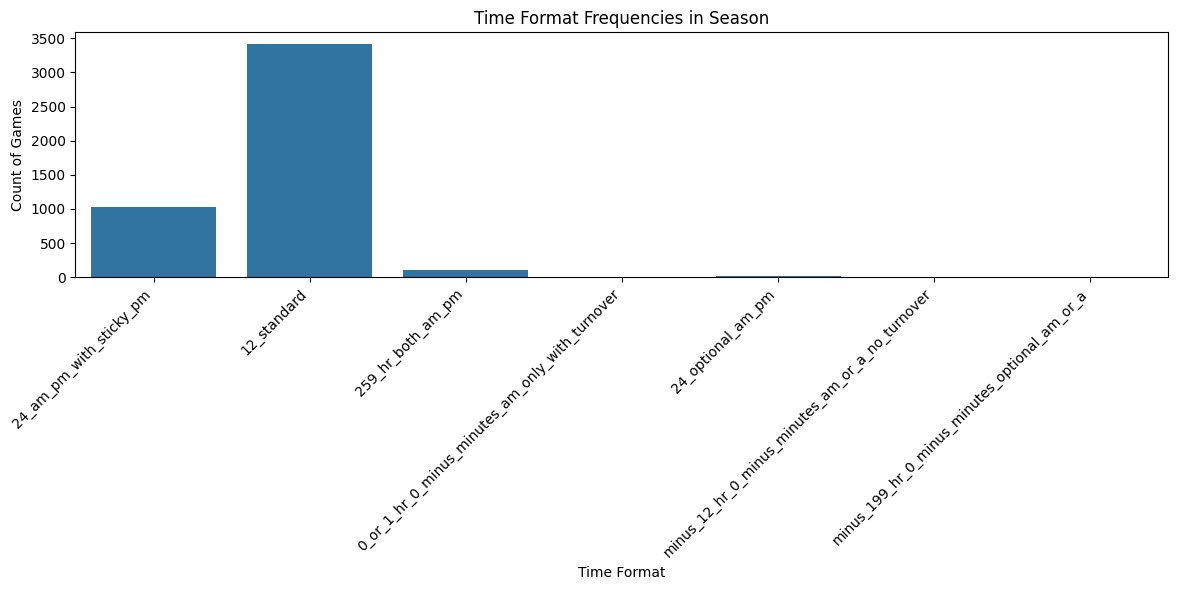

In [105]:
CHOSEN_SEASONS = ['1996-97', '1997-98', '1998-99', '1999-00']
# CHOSEN_SEASONS = os.listdir('../pbp_data/nba/') # Uncomment to process all seasons

plot_time_patterns(get_total_season_time_patterns(CHOSEN_SEASONS))

### Testing the Patterns

The below test suite is intended to verify that the regular expressions for time formats are functioning correctly.

In [106]:
# Example test cases for the regex patterns in order
# TODO: Extensively test pattern combinations rather than repeating the same patterns.
# TODO: Example: Define 12-hour pattern examples, 24-hour pattern examples, 12-hour with AM/PM, etc.
# TODO: Then, test combinations of the defined patterns.

import unittest

class TestTimeFormats(unittest.TestCase):
    def test_12_standard(self):
        valid = ['01:00 AM', '9:30 AM', '11:59 AM', '12:00 PM', '11:45 PM', '12:00 AM']
        invalid = ['13:00 AM', '00:00 PM', '12:60 AM', '12:61 PM', '12:00', '99:00 AM', '99:00', 'AD32:00 PM', '12:00 AM PM']
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['12_standard'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['12_standard'])

    def test_24_standard(self):
        valid = ['00:00', '01:00', '12:30', '23:59', '22:15', '15:00', '09:05', '10:00']
        invalid = ['24:00', '12:60', '12:61', '99:00', '99:59', '12:00 AM', '12:00 PM', '24:00 AM', '99:00', '99:00 PM', '12:00 AM PM', 'AD32:00 PM']
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['24_standard'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['24_standard'])

    def test_24_am_pm_with_sticky_pm(self):
        valid = ['00:00 AM', '01:00 AM', '12:30 PM', '23:59 PM', '22:15 PM', '15:00 PM', '09:05 AM', '10:00 PM']
        invalid = ['24:00 AM', '12:60 PM', '12:61 AM', '99:00 PM', '99:59 AM', '12:00 AM', '24:00 PM', '99:00 AM', '99:00 AM', 'AD32:00 PM']
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['24_am_pm_with_sticky_pm'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['24_am_pm_with_sticky_pm'])

    def test_24_optional_am_pm(self):
        valid = ['00:00', '01:00', '12:30', '23:59', '22:15', '15:00', '09:05', '10:00', '01:00 AM', '12:30 PM']
        invalid = ['24:00', '12:60', '12:61', '99:00', '99:59', '12:00 AM', '24:00 AM', '99:00 PM', '99:00 AM', 'AD32:00 PM']
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['24_optional_am_pm'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['24_optional_am_pm'])
    
    def test_99_hr_am_pm_with_sticky_pm(self):
        valid = ['00:00 AM', '01:00 AM', '12:30 PM', '23:59 PM', '22:15 PM', '15:00 PM', '09:05 AM', '10:00 PM',
                 '99:00 PM', '99:59 PM', '99:30 PM', '99:59 PM']
        invalid = ['24:00 AM', '12:60 PM', '12:61 AM', '100:59 AM', '12:00 AM',
                   '100:00 AM', '100:00 PM', 'AD32:00 PM']
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['99_hr_am_pm_with_sticky_pm'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['99_hr_am_pm_with_sticky_pm'])
    
    def test_99_hr_optional_am_pm(self):
        valid = ['00:00', '01:00', '12:30', '23:59', '22:15', '15:00', '09:05', '10:00',
                 '99:00', '99:59', '99:30', '99:59 PM', '09:05 AM', '10:00 PM']
        invalid = ['12:60', '12:61', '100:59 AM', '12:00 AM',
                   '100:00 AM', '100:00 PM', 'AD32:00 PM']
        
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['99_hr_optional_am_pm'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['99_hr_optional_am_pm'])

    def test_0_or_1_hr_0_minus_minutes_am_only_with_turnover(self):
        valid = ['0:0-51 AM', '0:58 AM', '0:0-45 AM', '0:0-20 AM', '1:58 AM', '0:0-51 AM', '0:0-20 AM']
        invalid = ['0:1-60 AM', '0:0-60 AM', '0:0-61 PM', '0:0-61 AM', '0:0-60 PM',
                   '0:0-30 PM', '0:0-29 PM', '0:0-59 PM', '1:0-51 PM', '1:0-60 AM',
                   '0:0-00 PM', '1:0-51 PM', '1:0-60 PM', '1:0-61 AM', '1:0-61 PM', '1:0-60 AM',]
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['0_or_1_hr_0_minus_minutes_am_only_with_turnover'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['0_or_1_hr_0_minus_minutes_am_only_with_turnover'])

    def test_0_or_1_hr_0_minus_minutes_pm_only_with_turnover(self):
        valid = ['0:0-51 PM', '0:58 PM', '0:0-45 PM', '0:0-20 PM', '1:58 PM', '0:0-51 PM', '0:0-20 PM']
        invalid = ['0:1-60 PM', '0:0-60 PM', '0:0-61 AM', '0:0-61 PM', '0:0-60 AM',
                   '0:0-30 AM', '0:0-29 AM', '0:0-59 AM', '1:0-51 AM', '1:0-60 PM',
                   '0:0-00 AM', '1:0-51 PM']
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['0_or_1_hr_0_minus_minutes_pm_only_with_turnover'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['0_or_1_hr_0_minus_minutes_pm_only_with_turnover'])

    def test_0_hr_0_minus_minutes_turnover(self):
        valid = ['0:0-51 AM', '0:58 AM', '0:0-45 PM', '0:0-20 PM', '0:0-51 PM', '0:58 PM', '0:0-45 AM', '0:0-20 AM']
        invalid = ['0:1-51 AM', '0:1-51 PM', '0:1-51', '0:1-60 PM', '0:0-60 PM', '0:0-61 AM', '0:0-61 PM', '0:0-60 AM', '0:1-60 AM',
                   '1:0-51 AM', '1:0-51 PM', '1:0-51', '1:0-60 PM', '1:0-61 AM', '1:0-61 PM', '1:0-60 AM',
                   '99:0-51 AM', '99:0-51 PM', '99:0-51', '99:0-60 PM', '99:0-61 AM', '99:0-61 PM', '99:0-60 AM',
                   '12:0-51 AM', '12:0-51 PM', '12:0-51', '12:0-60 PM', '12:0-61 AM', '12:0-61 PM', '12:0-60 AM']
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['0_hr_0_minus_minutes_turnover'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['0_hr_0_minus_minutes_turnover'])

    def test_259_hr_am_pm_with_sticky_pm(self):
        valid = [
            "4:00 AM", "0:00 AM", "11:59 AM", "12:00 PM", "16:00 PM", "23:59 PM", "24:00 PM", "99:00 PM", "99:59 PM", "100:00 PM",
            "199:59 PM", "200:16 PM", "200:20 PM"
        ]
        invalid = [
            "13:00 AM", "12:00 AM", "0:00 PM", "200:20 AM", "200:16 AM", "200:00 AM", "1:00 A", "1:00", "12:00", "200:00"
        ]
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['259_hr_am_pm_with_sticky_pm'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['259_hr_am_pm_with_sticky_pm'])

    def test_minus_12_hr_0_minus_minutes_am_or_a_no_turnover(self):
        valid = ['-10:0-7 AM', '-10:0-6 AM', '-10:0-5 AM', '-10:0-3 AM', '-10:0-2 AM', '-10:0-1 AM', '-10:00 AM',
            '-9:0-59 AM', '-9:0-57 AM', '-9:0-56 AM', '-9:0-55 AM', '-9:0-54 AM', '-9:0-53 AM', '-9:0-52 AM',
            '-9:0-50 AM', '-9:0-49 AM', '-9:0-48 AM', '-9:0-47 AM', '-9:0-46 AM', '-9:0-45 AM', '-9:0-44 AM',
            '-9:0-43 AM', '-9:0-42 AM', '-9:0-41 AM', '-9:0-40 AM', '-0:0-10 AM', '-0:0-10 A', '-0:0-3 AM', '-0:0-3 A']
        invalid = ['0:00 AM', '11:59 AM', '12:00 PM', '23:59 PM', '25:00 PM', '259:59 PM', '0:0-20 AM',
            '1:05 AM', '-0:05 AM']
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['minus_12_hr_0_minus_minutes_am_or_a_no_turnover'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['minus_12_hr_0_minus_minutes_am_or_a_no_turnover'])

    def test_259_hr_both_am_pm(self):
        valid = [
            "0:00 AM", "11:58 AM", "11:59 AM", "12:00 PM", "12:01 PM", "1:51 PM", "25:59 PM", "25:30 AM",
            "176:57 AM", "259:59 PM", "259:59 AM"
        ]
        invalid = ['0:00 A', '12:50 P', '12:00', '', '-9:0-40 AM', '-0:0-10 AM', '-0:0-10 A', '-0:0-3 AM', '-0:0-3 A', '0:0-20 AM', '-0:05 AM']
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['259_hr_both_am_pm'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['259_hr_both_am_pm'])

    def test_minus_199_hr_0_minus_minutes_optional_am(self):
        valid = [
            "-180:0-25", "-180:0-9 A", "-179:00 AM", "-199:0-59", "-199:0-58 A", "-199:0-57 AM"
        ]

        invalid = [
            "-180:0-25 PM", "-179:00 PM", "-199:0-59 PM", "-199:0-58 PM", "-199:0-57 PM",
            "-180:0-25 P", "-179:00 P", "-199:0-59 P", "-199:0-58 P", "-199:0-57 P",
            "-200:0-59", "-200:0-58 A", "-200:0-57 AM", "-200:0-56 PM", "-200:0-55 P",
            "4:00 AM", "4:00 PM", "4:00 A", "4:00 P", "4:00", "12:00 AM", "12:00 PM", "12:00 A", "12:00 P",
            "0:00 AM", "0:00 PM", "0:00 A", "0:00 P", "13:00 AM", "13:00 PM", "13:00 A", "13:00 P",
            "24:00 AM", "24:00 PM", "24:00 A", "24:00 P", "25:00 PM", "25:00 P", "25:00",
            "99:00 PM", "99:00 P", "99:00", "100:00 PM", "100:00 P", "100:00"
        ]
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['minus_199_hr_0_minus_minutes_optional_am_or_a'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['minus_199_hr_0_minus_minutes_optional_am_or_a'])

    def test_minus_12_hr_0_minus_minutes_positive_00_minutes_optional_am_or_a_with_4am_exception_and_minus_00_minutes_am_only_exception(self):
        valid = [
            "-10:0-48 A", "-10:0-9 AM", "-9:0-59 AM", "-8:0-44 AM", "4:00 AM", "-10:00 AM", "-9:00 AM"
        ]
        invalid = [
            "-10:0-48 PM", "-10:0-9 PM", "-9:0-59 PM", "-8:0-44 PM", "-10:0-62 AM", "-10:0-62 PM",
            "-10:0-62 A", "-10:0-62 P", "-10:0-61 AM", "-10:0-61 PM", "-10:0-61 A", "-10:0-61 P",
            "4:00 PM", "-10:0-48 P", "-10:0-9 P", "-9:0-59 P", "-8:0-44 P", "4:00 P", "11:59 AM",
            "11:59 A", "11:59", "12:01 PM", "12:01 P", "12:01", "12:00 AM", "12:00 A", "12:00", 
            "0:00 AM", "0:00 A", "0:00", "13:00 AM", "13:00 A", "13:00", "13:01 PM", "13:01 P", "13:01",
            "24:00 AM", "24:00 A", "24:00", "24:01 PM", "24:01 P", "24:01",
            "25:00 PM", "25:00 P", "25:00", "99:00 PM", "99:00 P", "99:00", "100:00 PM", "100:00 P", "100:00"
        ]
        for time in valid:
            self.assertRegex(time, TIME_FORMATS['minus_12_hr_0_minus_minutes_positive_00_minutes_optional_am_or_a_with_4am_exception_and_minus_00_minutes_am_only_exception'])
        for time in invalid:
            self.assertNotRegex(time, TIME_FORMATS['minus_12_hr_0_minus_minutes_positive_00_minutes_optional_am_or_a_with_4am_exception_and_minus_00_minutes_am_only_exception'])

    unittest.main(argv=[''], verbosity=2, exit=False)

test_0_hr_0_minus_minutes_turnover (__main__.TestTimeFormats.test_0_hr_0_minus_minutes_turnover) ... ok
test_0_or_1_hr_0_minus_minutes_am_only_with_turnover (__main__.TestTimeFormats.test_0_or_1_hr_0_minus_minutes_am_only_with_turnover) ... ok
test_0_or_1_hr_0_minus_minutes_pm_only_with_turnover (__main__.TestTimeFormats.test_0_or_1_hr_0_minus_minutes_pm_only_with_turnover) ... ok
test_12_standard (__main__.TestTimeFormats.test_12_standard) ... ok
test_24_am_pm_with_sticky_pm (__main__.TestTimeFormats.test_24_am_pm_with_sticky_pm) ... ok
test_24_optional_am_pm (__main__.TestTimeFormats.test_24_optional_am_pm) ... ok
test_24_standard (__main__.TestTimeFormats.test_24_standard) ... ok
test_259_hr_am_pm_with_sticky_pm (__main__.TestTimeFormats.test_259_hr_am_pm_with_sticky_pm) ... ok
test_259_hr_both_am_pm (__main__.TestTimeFormats.test_259_hr_both_am_pm) ... ok
test_99_hr_am_pm_with_sticky_pm (__main__.TestTimeFormats.test_99_hr_am_pm_with_sticky_pm) ... ok
test_99_hr_optional_am_pm (__m